# Advanced Lane Detection

This implementation tries to find the current driving lane of a car. It is based on the technicts taught in the online course ["Self Driving Car Engineer" from Udacity](https://udacity.com/course/self-driving-car-engineer-nanodegree--nd013) and on the paper ["Real time Detection of Lane Markers in Urban Streets" by Mohamed Aly](http://www.mohamedaly.info/research/lane-detection)


## Image Distortion and Top View

This helps to remove perspective effects in an images. Lines that are actually parallel, converge at the horizon in an images captured by a camera. The calculation of a top view gets rid of this effect, so that lanes appear parallel. 

In [1]:
import glob
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# See jupyter notebook Camera_Calibration.jpynb
dist_pickle = pickle.load( open( "camera_cal_data/camera_calibration_data.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

plt_img_width = 10
plt_img_height = 8

def top_view(img, mtx, dist, corners, margin_horz):
    # undistort image
    img_undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    # top left, top right, bottom right, bottom left
    # project video
    #corners = [[582,458], [700,458], [1012, 658], [295,658]]
    #margin_horz = 260
    
    # challenge video
    # corners = [[602,484], [730,484], [1022, 674], [340,674]]
    # margin_horz = 300
    
    img_height, img_width, img_depth = img.shape
    
    margin_vert = 0
   
    src_rect = np.float32(
        [corners[0], 
        corners[1],
        corners[2],
        corners[3]])

    dest_rect= np.float32([
        [margin_horz,             margin_vert],
        [img_width - margin_horz, margin_vert],
        [img_width - margin_horz, img_height - margin_vert],
        [margin_horz,             img_height - margin_vert]])

    M = cv2.getPerspectiveTransform(src_rect, dest_rect)
    Minv = cv2.getPerspectiveTransform(dest_rect, src_rect)
    warped = cv2.warpPerspective(img_undistorted, M, (img_width, img_height))
    return warped, M, Minv
                                 


This is an orignal image from camera

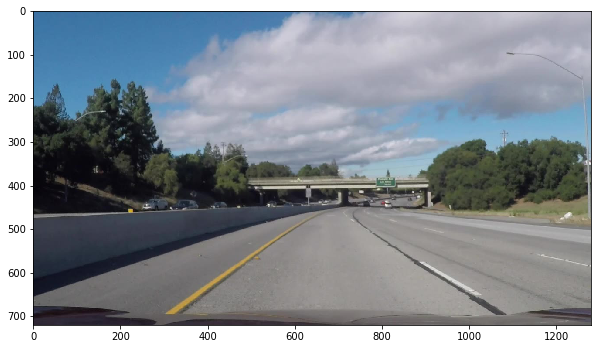

In [285]:
# read a distorted image
'''

distorted_image = mpimg.imread('test_images/straight_lines2.jpg')
distorted_image = mpimg.imread('test_images/project_video/image-027.jpg')

# top left, top right, bottom right, bottom left corners of
# a straight lane
# project video
corners = [[555,475], [733,475], [1009, 647], [311,647]]
corners = [[571,464], [713,464], [1032, 661], [288,661]]
margin_horz = 240
'''

distorted_image = mpimg.imread('test_images/challenge/image-002.jpg')

# top left, top right, bottom right, bottom left corners of
# a straight lane
# challenge video
corners = [[602,484], [730,484], [1022, 674], [340,674]]
margin_horz = 300

# show the distorted image
plt.figure(figsize=(plt_img_width,plt_img_height))
plt.imshow(distorted_image)


And this is the undistorted top view

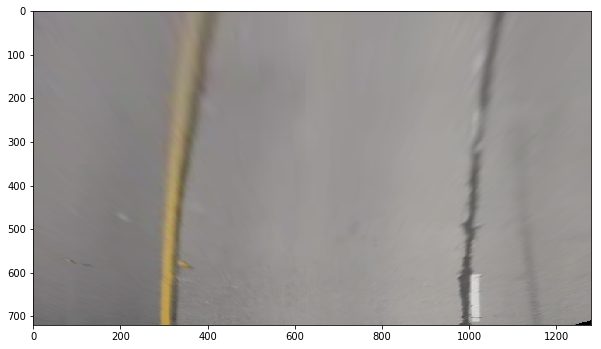

In [286]:
# read a distorted image
topview_image, M, Minv = top_view(distorted_image, mtx, dist, corners, margin_horz) 

# show the distorted image
plt.figure(figsize=(plt_img_width,plt_img_height))
plt.imshow(topview_image)

# image dimensions
topview_image_height, topview_image_width, topview_image_depth = topview_image.shape 

This show the undistorted top view of all test images

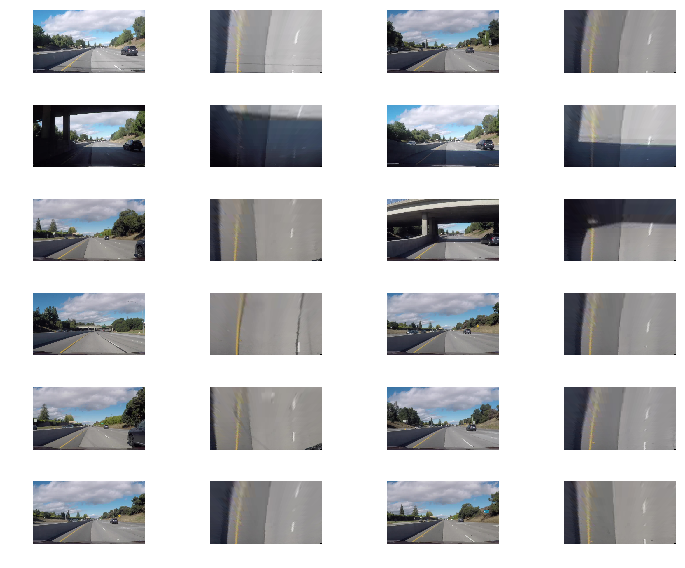

In [262]:
#test_images_file_filter = 'test_images/*.jpg'
#test_images_file_file_names = glob.glob(test_images_file_filter)

test_images_file_filter = 'test_images/challenge/*.jpg'
test_images_file_file_names = glob.glob(test_images_file_filter)[::4]
undistorted_top_views = []
distorted_images = []

fig, axs = plt.subplots(ncols=4, nrows=int(len(test_images_file_file_names) / 2), figsize=(plt_img_width, plt_img_height))
axs = axs.ravel()

for index, distorted_image_file_name in zip(range(len(test_images_file_file_names)), test_images_file_file_names):
    if (index * 2 + 1) >= len(axs):
        break
        
    image = mpimg.imread(distorted_image_file_name)
    distorted_images.append(image)
    
    topview_image_gallery, M, Minv = top_view(image, mtx, dist, corners, margin_horz)
    undistorted_top_views.append(topview_image_gallery)
    
    axs[index*2].imshow(image)
    axs[index*2].set_axis_off()
    axs[index*2+1].imshow(topview_image_gallery)
    axs[index*2+1].set_axis_off()
    
plt.tight_layout()


## Adjust Brightness and contrast

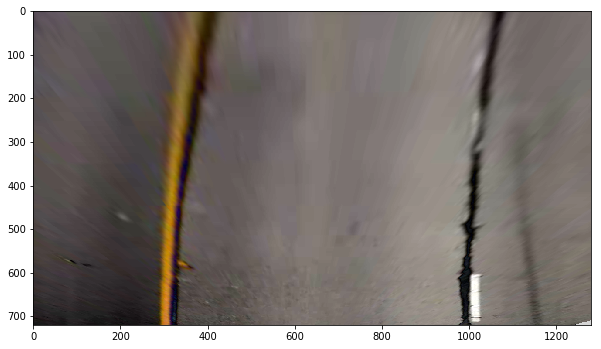

In [288]:
def adjust_brightness_and_contrast(image):
    # http://answers.opencv.org/question/75510/how-to-make-auto-adjustmentsbrightness-and-contrast-for-image-android-opencv-image-correction/
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    
    max_val = 255
    min_val = 0
    hist_threshold_value_max = 400
    hist_threshold_value_min = 4000
    bright_pixel = 0
    dark_pixel = 0
    
    for i in range(len(hist) - 1,0, -1):
        bright_pixel += hist[i] 
        if (bright_pixel > hist_threshold_value_max):
            max_val = i
            break
    
    for i in range(0, len(hist) - 1):
        dark_pixel += hist[i]
        if (dark_pixel > hist_threshold_value_min):
            min_val = i
            break
    
    #print(min_val)
    #print(max_val)
    
    input_range = max_val - min_val
    wanted_output_range = 255
    alpha = wanted_output_range / input_range
    beta = -min_val * alpha
    adjusted_image = cv2.convertScaleAbs(src=image, alpha=alpha, beta=beta)
    #plt.figure(figsize=(plt_img_width,plt_img_height))
    #plt.plot(hist)
    #plt.show()

    return adjusted_image
    
# show the distorted image
plt.figure(figsize=(plt_img_width,plt_img_height))
adjusted_top_view_image = adjust_brightness_and_contrast(topview_image)
#adjusted_top_view_image = adjust_brightness_and_contrast(undistorted_top_views[2])
plt.imshow(adjusted_top_view_image)
#adjust_brightness_and_contrast(topview_image)
    


## Evaluation of color channel

Lane dividers have two major color properties, saturation and lightness, to contrast with the road. We may take advantages of this by transforming the image to the HLS color space.

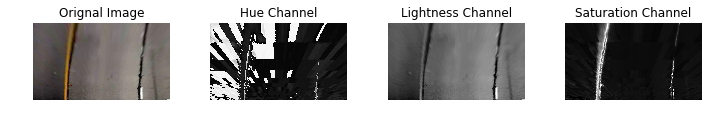

In [289]:
def show_hls_color_channels(channel_eval_image):
    hls_image = cv2.cvtColor(channel_eval_image, cv2.COLOR_RGB2HLS)
    h_channel = hls_image[:,:,0]
    l_channel = hls_image[:,:,1]
    s_channel = hls_image[:,:,2]
    
    fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(plt_img_width, plt_img_height))
    axs[0].set_title("Orignal Image")
    axs[0].imshow(channel_eval_image)
    axs[0].set_axis_off()
    axs[1].set_title("Hue Channel")
    axs[1].imshow(h_channel / 100.0, cmap='gray')
    axs[1].set_axis_off()
    axs[2].set_title("Lightness Channel")
    axs[2].imshow(l_channel, cmap='gray')
    axs[2].set_axis_off()
    axs[3].set_title("Saturation Channel")
    axs[3].imshow(s_channel, cmap='gray')
    axs[3].set_axis_off()
    plt.tight_layout()
    
#show_hls_color_channels(undistorted_top_views[0])
show_hls_color_channels(adjust_brightness_and_contrast(topview_image))



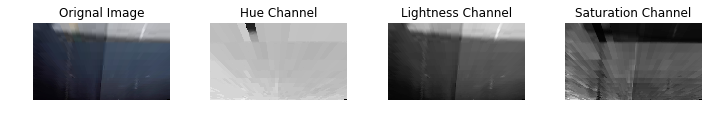

In [290]:
show_hls_color_channels(undistorted_top_views[2])

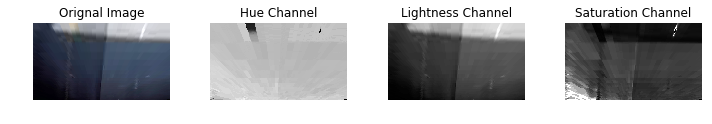

In [291]:
show_hls_color_channels(adjust_brightness_and_contrast(undistorted_top_views[2]))

We can see that the saturation channel is suitable to extract yellow lines, whereas the lightness channel seems to extract white markes. 

## Marker extraction

Different to the approach from Udacity, I use gaussian spatial filters to detect vertical lines, as described in Mohamed Aly's paper on the lighness channel and on the saturation channel. The respons
e of this filter is then thresholded and merged.

In [180]:
# calucate the derivative of a gaussian
def get_derivative_gaussian(w, sigma):
    d = np.zeros(w*2+1)    
    
    for x in range(-w,w+1):
        i = x + w
        d[i] = (1.0/sigma**2) * np.exp((-(x**2)) / (2 * sigma**2)) * (1 - (x**2 / sigma**2)) 
    
    return d

# calculate a gaussian
def get_gaussian(w, sigma):
    g = np.zeros(w*2+1)
    
    for x in range(-w,w+1):
        i = x + w
        g[i] = np.exp(-((x**2)/(2*sigma**2)))
    
    return g

# combine the derivative of a gaussian and a gaussian to a kernel
def get_convolution_kernel(kernel_width, kernel_height, sigma_width, sigma_height):
    derivative_gaussian = np.mat(get_derivative_gaussian(kernel_width,sigma_width))
    gaussian = np.mat(get_gaussian(kernel_height, sigma_height))
    kernel = gaussian.T * derivative_gaussian
    return kernel


### Gaussian Curves


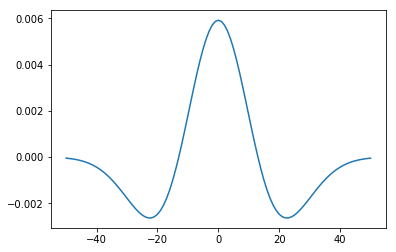

In [181]:
xm_per_pix = 3.7/700
ym_per_pix = 30.0/720

kernel_width = 50 # 25
sigma_width = 13 #10 # 5
t1 = np.arange(-kernel_width, kernel_width+1)
plt.plot(t1, get_derivative_gaussian(kernel_width,sigma_width))

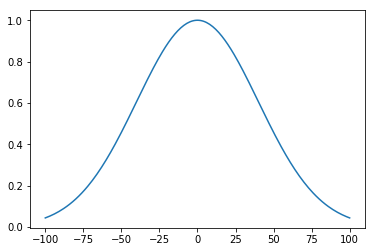

In [182]:
kernel_height = 100 #10
sigma_height = 40 # 6
t2 = np.arange(-kernel_height, kernel_height+1)
plt.plot(t2, get_gaussian(kernel_height,sigma_height))

### Spatial Filter Kernel


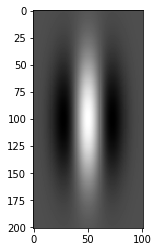

In [183]:
spatial_filter = get_convolution_kernel(kernel_width, kernel_height, sigma_width, sigma_height)
cv2.normalize(spatial_filter,spatial_filter)

plt.imshow(spatial_filter, cmap='gray')

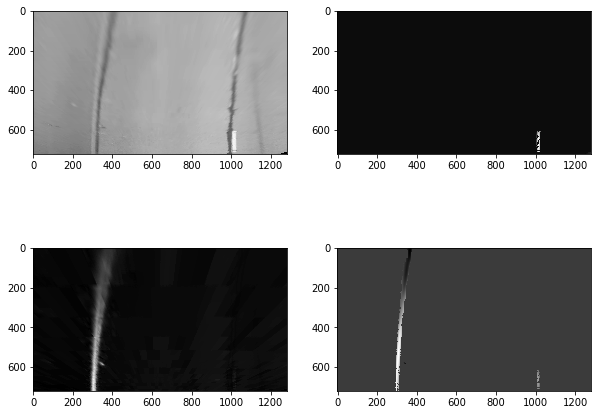

In [300]:
def threshold(image, min, max):
    '''
    smooth_image = cv2.GaussianBlur(
        src=np.float32(image), ksize=(99,99), sigmaX=10.0, sigmaY=20)
    '''
    
    normalized = image.copy()
    normalized[normalized < 0] = 0
    normalized = cv2.normalize(
        normalized, 0,255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    _, normalized = cv2.threshold(normalized,min,max,cv2.THRESH_TOZERO)
    return normalized

def filter_image(image, kernel):
    image = adjust_brightness_and_contrast(image)
    hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    #h_channel = hls_image[:,:,0]
    l_channel = hls_image[:,:,1]
    s_channel = hls_image[:,:,2]

    
    # filter for yellow
    lower_yellow = np.array([15,80,60])
    upper_yellow = np.array([30,255,255])
    mask_yellow = cv2.inRange(hls_image, lower_yellow, upper_yellow)
    
    #s_channel = cv2.bitwise_and(s_channel,s_channel, mask= mask)
    # s_channel = threshold(s_channel, 120.0, 255.0)

    #l_channel = threshold(l_channel, 100.0, 255.0)
    
    # filter image
    l_channel_filtered = cv2.filter2D(l_channel, cv2.CV_32F, kernel)
    s_channel_filtered = cv2.filter2D(s_channel, cv2.CV_32F, kernel)
    
    (minVal, maxVal , _, _) = cv2.minMaxLoc(l_channel_filtered)
    range = maxVal - minVal


    #filter for white
    lower_white= np.array([0,190,0])
    upper_white = np.array([180,255,200])
    mask_white = cv2.inRange(hls_image, lower_white, upper_white)

    #mask_white = cv2.inRange(l_channel, 200, 255)
    #mask_white = cv2.inRange(l_channel, 190, 255)

    l_channel_filtered = cv2.bitwise_and(l_channel_filtered,l_channel_filtered, mask= mask_white)
    s_channel_filtered = cv2.bitwise_and(s_channel_filtered,s_channel_filtered, mask= mask_yellow)
    
    # normalize
    l_channel_filtered = ((l_channel_filtered - minVal) / range)
    
    (minVal, maxVal , _, _) = cv2.minMaxLoc(s_channel_filtered)
    range = maxVal - minVal
    s_channel_filtered = ((s_channel_filtered - minVal) / range)
    
    '''
    hist = cv2.calcHist([l_channel_filtered], [0], None, [256], [0.8, 1])
    plt.figure(figsize=(plt_img_width,plt_img_height))
    plt.plot(hist)
    plt.show()
    '''

    #l_channel_filtered = threshold(l_channel_filtered, 220.0, 255.0)
    return l_channel_filtered, s_channel_filtered
   
image_to_filter = topview_image

filtered_l_channel, filtered_s_channel = filter_image(image_to_filter,spatial_filter)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(plt_img_width, plt_img_height))
axs[0,0].imshow(cv2.cvtColor(image_to_filter, cv2.COLOR_RGB2HLS)[:,:,1], cmap='gray')
axs[0,1].imshow(filtered_l_channel, cmap='gray')
axs[1,0].imshow(cv2.cvtColor(image_to_filter, cv2.COLOR_RGB2HLS)[:,:,2], cmap='gray')
axs[1,1].imshow(filtered_s_channel, cmap='gray')



### Thresholded images

The lightness and saturation image are blured to remove noise and then thresholded.

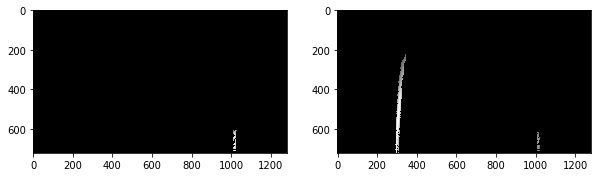

In [301]:
normalized_filtered_l_channel = threshold(filtered_l_channel, 100.0, 255.0)
normalized_filtered_s_channel = threshold(filtered_s_channel, 100.0, 255.0)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(plt_img_width, plt_img_height))
axs[0].imshow(normalized_filtered_l_channel, cmap='gray')
axs[1].imshow(normalized_filtered_s_channel, cmap='gray')


### Merged Image

The lanes stand out now clearly. Both images are more here to visualize the lane markers in one image. But that is not useful for further processing, as the yellow line on the right would be merged with the obstackle on th the road. 

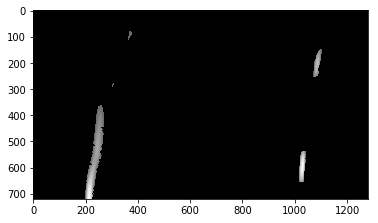

In [186]:
processed_image = np.maximum(normalized_filtered_l_channel, normalized_filtered_s_channel)
plt.imshow(processed_image, cmap='gray')

### Find line canditates

The canditates for lines are found using a smoothed histogram. The local maxima in the histogram are used as a location hypothesis for line extraction. 



In [27]:
def bottom_smoothed_histogram(image):
    height = image.shape[0]
    bottom = image[height - height//3:, :]
    histogram = np.sum(bottom, axis=0)
    
    smooth_histogram = cv2.GaussianBlur(
        src=np.float32(histogram), ksize=(1,19), sigmaX=19.0)
    
    '''
    window_width = 50
    window = np.ones(window_width)
    conv_signal = np.convolve(window, histogram)
    '''

    return np.int_(smooth_histogram.flatten())

# Create histogram of image binary activations
lane_histogram = bottom_smoothed_histogram(processed_image)

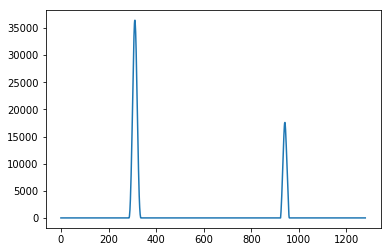

In [28]:
from skimage.feature import peak_local_max

# find the peaks in the histogram
histogram_peak_idx = peak_local_max(lane_histogram, min_distance=50, threshold_abs=400000)
histogram_peak_values =  lane_histogram[histogram_peak_idx]

# Visualize the resulting histogram and show the peaks
fig, ax = plt.subplots()
ax.plot(lane_histogram)
ax.plot(histogram_peak_idx,histogram_peak_values, '*')



### Find lanes

Sliding windows are drawn around the candidates and moved up along a probable path to the top of the images. If a window doesn't contain enough points, the area is not taken into account for further processing. The algorith stops if there are too many empty windows or the top of the image is reached.

Based on the points in the sliding windows polynomials are extracted.


In [69]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.all_x = None  
        #y values for detected line pixels
        self.all_y = None
        #length (ratio) of this line
        self.length = 0.0        
        #line type (0 = unknown, 1 = yellow, 2 = white)
        self.type = 0

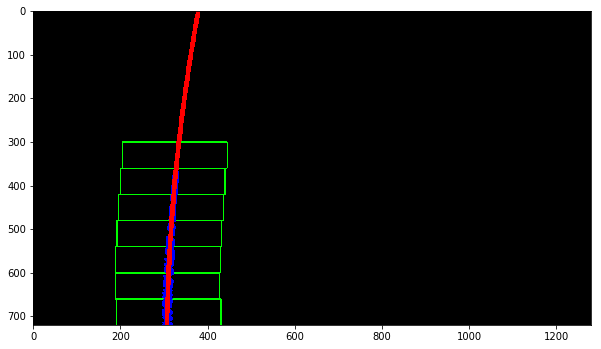

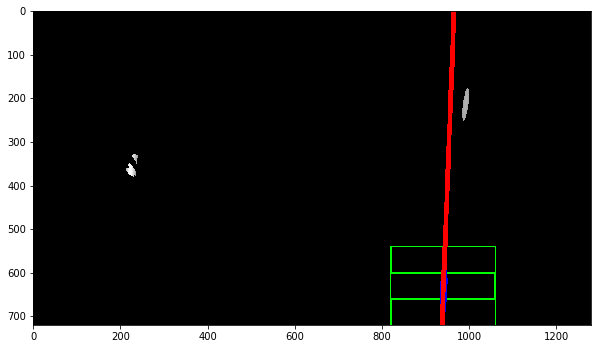

In [34]:
# get the middle point of plateaus 
def filter_local_maxima(local_maxima, gap):
    group = []
    filtered_local_maxima = []
    last_index = 0
    
    for maximum_index in local_maxima:
        if abs(maximum_index - last_index) > gap:
            group_size = len(group) 
            if group_size == 1:
                filtered_local_maxima.append(int(group[0]))
            
            if group_size > 1:
                filtered_local_maxima.append(int(group[0] + (group[group_size-1] - group[0]) / 2))
                
            group.clear()
        
        group.append(maximum_index)
        last_index = maximum_index

    group_size = len(group)
    
    if group_size == 1:
        filtered_local_maxima.append(int(group[0]))
    
    if group_size > 1:
        filtered_local_maxima.append(int(group[0] + (group[group_size-1] - group[0]) / 2))
                
    return filtered_local_maxima

    
def find_lane_pixels(image, image_type, n_search_windows, search_window_margin, minpix):
    out_img = np.dstack((image, image, image))
    
    lane_histogram = bottom_smoothed_histogram(image)
    
    # find the peaks in the histogram
    #histogram_peak_idxs = peak_local_max(lane_histogram, min_distance=50, threshold_abs=400000)
    histogram_peak_idxs = peak_local_max(lane_histogram, min_distance=50, threshold_abs=10000)
    
    
    # filter plateaus
    lane_positions = filter_local_maxima(histogram_peak_idxs, 10)
    
    #histogram_peak_values =  lane_histogram[histogram_peak_idxs]
    
    # Visualize the resulting histogram and show the peaks
    # fig, ax = plt.subplots()
    # ax.plot(lane_histogram)
    # ax.plot(histogram_peak_idxs,histogram_peak_values, '*')

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(image.shape[0]//n_search_windows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    good_lanes_inds = []
    lane_lengths = []
    
    image_height = image.shape[0]
    
    for lane_position_idx in range(len(lane_positions)):
        lane_inds = []
        current_lane_pos = lane_positions[lane_position_idx]
        last_shift = 0
        empty_box_count = 0
        max_empty_boxes = 4
        lane_length = 0.0
        
        for window in range(n_search_windows):
            win_y_low = image_height - (window + 1) * window_height
            win_y_high = image_height - window * window_height

            win_x_low = current_lane_pos - search_window_margin
            win_x_high = current_lane_pos + search_window_margin
            
            # Identify the nonzero pixels in x and y within the window #
            good_lane_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]
            
          
            ### If you found > minpix pixels, recenter next window ###
            if len(good_lane_inds) > minpix:
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(win_x_low,win_y_low),
                (win_x_high,win_y_high),(0,255,0), 2)

                new_lane_pos = np.int(np.mean(nonzerox[good_lane_inds]))
                last_shift = new_lane_pos - current_lane_pos
                current_lane_pos = new_lane_pos
                lane_inds.append(good_lane_inds)
                empty_box_count = 0
                lane_length += window_height
            else:
                current_lane_pos += last_shift
                empty_box_count += 1
                
            # if there are too many empty boxes stop search
            if (empty_box_count >= max_empty_boxes):
                break
    
        # Concatenate the arrays of indices (previously was a list of lists of pixels)        
        try:
            lane_inds = np.concatenate(lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass
            
        good_lanes_inds.append(lane_inds)    

    lines = []
    
    # Extract left and right line pixel positions
    for lane_position_idx in range(len(lane_positions)):
        line = Line()
        line.all_x = nonzerox[good_lanes_inds[lane_position_idx]]
        line.all_y = nonzeroy[good_lanes_inds[lane_position_idx]]
        line.type = image_type
        lines.append(line)        
    
    return lines, out_img

def get_lane_points(fit_params, image_height, max_points):
    if (len(fit_params) < 3):
        return [], []
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, image_height-1, max_points)
    fitx = fit_params[0]*ploty**2 + fit_params[1]*ploty + fit_params[2]
   
    return fitx, ploty
    

def lane_fitting(lines, image, draw):
    image_height = image.shape[0]    
    
    for i in range(len(lines)):        
        line = lines[i]
        
        if (len(line.all_x) < 2 or len(line.all_y) < 2):
            continue
            
        fit_params = np.polyfit(line.all_y, line.all_x, 2)
        line.current_fit = fit_params
        
        if draw == True:
            fitx, ploty = get_lane_points(fit_params, image_height, image_height)
            
            ## Visualization ##
            # Colors in the left and right lane regions
            image[line.all_y, line.all_x] = [0, 0, 255]
    
            # Plots the left and right polynomials on the lane lines
            laneline = np.array([np.transpose(np.vstack([fitx, ploty]))])
            cv2.polylines(image, np.int_([laneline]), False, (255,0, 0), thickness=10, lineType=4)
            #plt.plot(fitx, ploty, color='red')

        
lines_l_channel, sliding_window_image_l_channel = find_lane_pixels(normalized_filtered_l_channel, 2, 12, 120, 50)  
lane_fitting(lines_l_channel, sliding_window_image_l_channel, draw=True)

lines_s_channel, sliding_window_image_s_channel = find_lane_pixels(normalized_filtered_s_channel, 1, 12, 120, 50)  
lane_fitting(lines_s_channel, sliding_window_image_s_channel, draw=True)

plt.figure(figsize=(plt_img_width,plt_img_height))    
plt.imshow(sliding_window_image_s_channel)

plt.figure(figsize=(plt_img_width,plt_img_height))
plt.imshow(sliding_window_image_l_channel)


### Search lanes around polynom

Polynoms that where found in prior search will be used to find lines in the next image.

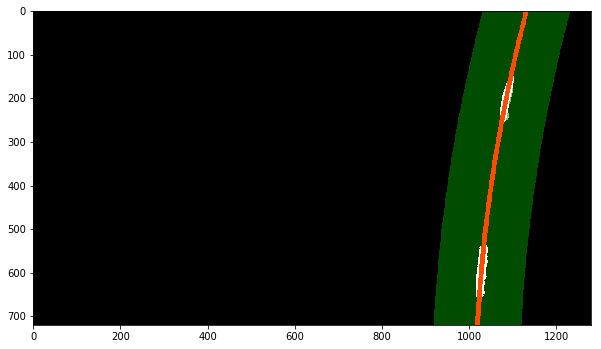

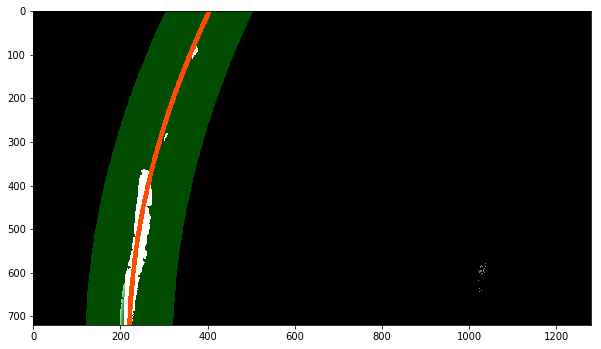

In [193]:
def search_lines_around_polynoms(lines, margin, image, draw):
    image_height = image.shape[0]
    
    # Grab activated pixels
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    out_img = []
    window_img = []
    result_image = []
    new_lines = []
    
    if draw == True:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((image, image, image))*255
        window_img = np.zeros_like(out_img)
    
    for i in range(len(lines)):
        line = lines[i]
        lane_fitting_params = line.current_fit
        
        if (len(lane_fitting_params) < 3):
            continue
        
        line_inds = ((nonzerox > (lane_fitting_params[0]*(nonzeroy**2) + lane_fitting_params[1]*nonzeroy + 
                      lane_fitting_params[2] - margin)) & (nonzerox < (lane_fitting_params[0]*(nonzeroy**2) + 
                      lane_fitting_params[1]*nonzeroy + lane_fitting_params[2] + margin)))
    
        
        # Again, extract line pixel positions
        new_line = Line()
        new_line.all_x = nonzerox[line_inds]
        new_line.all_y = nonzeroy[line_inds] 
        new_line.type = line.type
    
        # Fit new polynomials
        lane_fitting([new_line], image, draw=False)        
        
        new_lines.append(new_line)
        
        if draw == True:
            ## Visualization ##
            fitx, ploty = get_lane_points(new_line.current_fit, image_height, image_height)
            
            if (len(fitx) > 0 and len(ploty) > 0):
                # Color on lane pixel
                out_img[nonzeroy[line_inds], nonzerox[line_inds]] = [255, 255, 255]
            
                # Generate a polygon to illustrate the search window area
                # And recast the x and y points into usable format for cv2.fillPoly()
                line_window1 = np.array([np.transpose(np.vstack([fitx-margin, ploty]))])
                line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx+margin, 
                                          ploty])))])
                line_pts = np.hstack((line_window1, line_window2))
            
                # Draw the lane onto the warped blank image
                cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
    
                # Plot the polynomial lines onto the image
                laneline = np.array([np.transpose(np.vstack([fitx, ploty]))])
                cv2.polylines(out_img, np.int_([laneline]), False, (255,0, 0), thickness=10, lineType=4)
    
                result_image = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
                #plt.plot(fitx, ploty, color='red',  linewidth=5)
                ## End visualization steps ##
            else:
                result_image = out_img
    
    return new_lines, result_image

# Run image through the pipeline
normalized_filtered_l_channel_poly_lane_fit = normalized_filtered_l_channel.copy()
lines_l_channel, result_image_l_channel = search_lines_around_polynoms(
    lines_l_channel, 100, normalized_filtered_l_channel_poly_lane_fit, draw=True)

normalized_filtered_s_channel_poly_lane_fit = normalized_filtered_s_channel.copy()
lines_s_channel, result_image_s_channel = search_lines_around_polynoms(
    lines_s_channel, 100, normalized_filtered_s_channel_poly_lane_fit, draw=True)

# View your output
plt.figure(figsize=(plt_img_width,plt_img_height))    
plt.imshow(result_image_l_channel)

plt.figure(figsize=(plt_img_width,plt_img_height))    
plt.imshow(result_image_s_channel)

### Calculate Curvature

In [36]:
def meassure_curvature(polynomial, y, xm_per_pix, ym_per_pix, image_height):
    # generate new x and y values along the curve (use only a small subset of points)
    fitx, ploty = get_lane_points(polynomial, image_height, 50)
    
    if (len(fitx) < 2 or len(ploty) < 2):
        return 0.0, 0 
    
    fitx *= xm_per_pix
    ploty *= ym_per_pix
    
    # transform x and y coordinates to real world and fit a polynomial
    fit_params = np.polyfit(ploty, fitx, 2)
    
    if (len(fit_params) < 3):
        return 0.0, 0 
    
    A = fit_params[0]
    B = fit_params[1]
    R = 0
    
    y *= ym_per_pix
    
    if (A != 0.0):
        R = ((1 + (2 * A * y + B) ** 2) ** (3/2)) / np.abs(2 * A)
        
    return R, fitx[-1]

lane_points = []
xm_per_pix = 3.7/700
ym_per_pix = 30.0/720

lines = []
lines.extend(lines_l_channel)
lines.extend(lines_s_channel)

for i in range(len(lines)):
    image_height = processed_image.shape[0]
    R, lane_point = meassure_curvature(
        lines[i].current_fit, y=(image_height - 1), xm_per_pix = xm_per_pix, ym_per_pix = ym_per_pix, image_height=image_height)
    lane_points.append(lane_point)
    lines[i].radius_of_curvature = R
    print(R, "m")

1030.0698543823214 m
1445.3043854826683 m


### Vehicle Position

In [37]:
def get_vehicle_position(lane_points, image_width_in_m):
    pos_in_m = 0.0
    left = 0
    right = image_width_in_m
    middle = image_width_in_m / 2
    
    # get the closest points from center
    for lane_point in lane_points:
        if (lane_point > left and lane_point < middle):
            left = lane_point
        
        if (lane_point > middle and lane_point < right):
            right = lane_point
            
    pos_in_m = ((left + right) / 2 - middle)
    return pos_in_m

image_width = processed_image.shape[1]
car_position = get_vehicle_position(lane_points, image_width * xm_per_pix)
print('Car Position:', car_position, 'm')
    

Car Position: -0.09123909365711036 m


### Filter Polynomials

The gap between lane markings that confine a lane must be at least as broad as a car or truck. And also not much larger. The lane markings are also the ones that are described with the most pixels. These properties can be used to filter false markings.
 
The length of the line may tell how shure we are that this is a lane marking as lane markings should lead from the bottom to the top of an image.

In [214]:
# find the left and right lane markings
def get_left_right_params(lines, image_height, image_width, lane_min_width, lane_max_width):
    bottom_y = (image_height - 1) * 0.8
    middle = image_width / 2
    line_points = []
    left_i = -1
    right_i = -1
    left_line = Line()
    right_line = Line()
    poly_lines = []
    
    
    # calculate line points at the button of the image
    for line in lines:
        fit_params = line.current_fit
        if (len(fit_params) < 3):
            continue
            
        try:
            fitx = fit_params[0]*bottom_y**2 + fit_params[1]*bottom_y + fit_params[2]
            line_points.append(fitx)
            poly_lines.append(line)
            
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            '''
            print('The function failed to fit a line!')
            fitx = 1*bottom_y**2 + 1*bottom_y
            line_points.append(fitx)
            '''

    # count of points that define the two lines
    min_line_pixel = 0
    diff_a = float("inf")

    # keep pairs of line points with a min/max distance to each other
    for i in range(len(line_points)):
        line_point_l = line_points[i]
        a_l = poly_lines[i].current_fit[0]
        
        # line point must be on the left side
        if line_point_l < middle:
        
            for j in range(len(line_points)):
                line_point_r = line_points[j]
                a_r = poly_lines[j].current_fit[0]

                # line point must be on the right side
                if (line_point_r >= middle ):
                    
                    # distance of line points must be in min/max range
                    distance = line_point_r - line_point_l
                    if (distance >= lane_min_width) and (distance <= lane_max_width):
                        
                        # it can be assumed that lane dividers are parallel,
                        # so A from (Ax^2 + Bx + C) should be similar
                        # in both lines
                        if (abs(a_l - a_r) < diff_a):
                            diff_a = abs(a_l - a_r)
                        
    return left_line, left_i, right_line, right_i

def calc_length_of_line(line):
    if line is None:
        return 0.0

    if line.all_y is None:
        return 0.0
    
    if (len(line.all_y) == 0):
        return 0.0
    
    A = line.current_fit[0]
    B = line.current_fit[1]
    u = min(line.all_y) 
    v = max(line.all_y)
    
    if (u - v) == 0:
        return 0.0
    
    arclength = (np.arcsinh(2*A*v+B)+(2*A*v+B)*np.sqrt((2*A*v+B)**2+1)-
                 np.arcsinh(2*A*u+B)-(2*A*u+B)*np.sqrt((2*A*u+B)**2+1))/(4*A)
    
    return arclength
    


### Show current lane in the original image

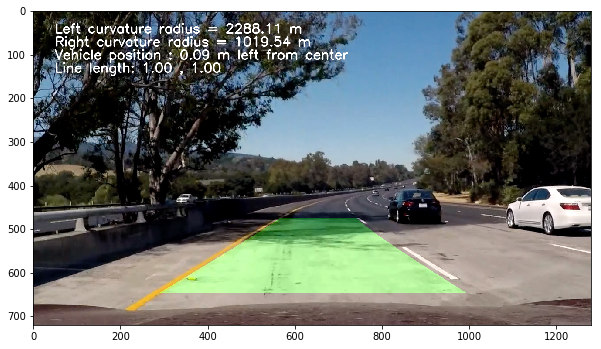

In [140]:
def draw_current_lane_on_image(processed_image_template, original_image, lines, Minv, position):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(processed_image_template).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    image_height = processed_image_template.shape[0]
    image_width = processed_image_template.shape[1]
    
    if (len(lines) != 2):
        return original_image
    
    left_line = lines[0]
    right_line = lines[1]

    if len(left_line.current_fit) < 3 or len(right_line.current_fit) < 3:
        return original_image

    R_left = left_line.radius_of_curvature
    R_right = right_line.radius_of_curvature
   
    left_fitx, ploty = get_lane_points(left_line.current_fit, image_height, image_height)
    right_fitx, ploty = get_lane_points(right_line.current_fit, image_height, image_height)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_width, image_height)) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Left curvature radius = %.2f m'%(R_left),(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Right curvature radius = %.2f m'%(R_right),(50,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Vehicle position : %.2f m %s from center'%(abs(position), 'left' if position < 0 else 'right'),(50,110), 
                        font, 1,(255,255,255),2,cv2.LINE_AA)
    
    left_line_length = left_line.length
    right_line_length = right_line.length
    cv2.putText(result,'Line length: %.2f , %.2f'%(abs(left_line_length), abs(right_line_length)),(50,140), 
                    font, 1,(255,255,255),2,cv2.LINE_AA)

    return result

# get only the left and right lane parameters
left_line, left_i, right_line, right_i = get_left_right_params(
    lines, 
    image_height=normalized_filtered_l_channel.shape[0], 
    image_width=normalized_filtered_l_channel.shape[1], 
    lane_min_width=500, lane_max_width=900)

plt.figure(figsize=(plt_img_width,plt_img_height))
plt.imshow(draw_current_lane_on_image(
    normalized_filtered_l_channel, distorted_image, [left_line, right_line], Minv=Minv, position=car_position))

In [307]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def count_polynomials(lines):
    i = 0
    for line in lines:
        if len(line.current_fit) == 3:
            i += 1
    
    return i

# The polynomials from previous and current detections are merged here.
# The length of the line from the the current detections is used as a 
# measure of trust. The longer the line the more we trust the new
# detection. The shorter the line the more we trust the previous detection.
def update_line_polynomials(prev_line, current_line, image_height):
    # use the line length as a measure of confidence to update previous parameters
    line_length = calc_length_of_line(current_line) / image_height
    if line_length > 1.0:
        line_length = 1.0
        
    current_line.length = line_length    
    trust = line_length ** 2
    
    #if trust > 0.7:
    #    trust = 0.7
        
    if (len(prev_line.current_fit) < 3):
        return 
    
    if (len(current_line.current_fit) == 3):        
        current_line.current_fit[0] = (prev_line.current_fit[0] * (1.0 - trust) +
                                      current_line.current_fit[0] * trust)
        
        current_line.current_fit[1] = (prev_line.current_fit[1] * (1.0 - trust) +
                                      current_line.current_fit[1] * trust)
        
        current_line.current_fit[2] = (prev_line.current_fit[2] * (1.0 - trust) +
                                      current_line.current_fit[2] * trust)
    else:
        current_line.current_fit = prev_line.current_fit


def lane_detection_pipeline(distorted_image, lines, corners, margin_horz):
   
    # read a distorted image
    topview_image, M, Minv = top_view(distorted_image, mtx, dist, corners, margin_horz)
    #return adjust_brightness_and_contrast(topview_image)
    
    # filter image for lines and get the saturation and lightness channel
    filtered_l_channel, filtered_s_channel = filter_image(topview_image, spatial_filter)
    
    # normalize and threshold the two channels
    normalized_filtered_l_channel = threshold(filtered_l_channel, 150.0, 255.0)
    normalized_filtered_s_channel = threshold(filtered_s_channel, 100.0, 255.0)

    '''

    warp_zero = np.zeros_like(normalized_filtered_s_channel).astype(np.uint8)
    
    color_warp = np.dstack((
        warp_zero, 
        normalized_filtered_s_channel.astype(np.uint8),
        normalized_filtered_l_channel.astype(np.uint8)))
    
    analyse_image = cv2.addWeighted(topview_image, 0.5, color_warp, 1.0, 0) 

    return analyse_image
    '''
    
    previous_detection = lines.copy()   
    previous_detection_image = np.zeros_like(normalized_filtered_s_channel).astype(np.uint8) 
    
    # don't forget the detections from previous step
    for line in lines:
        if (line is None) or (line.all_x is None) or (line.all_y is None):
            continue
            
        detections = np.transpose(np.vstack((line.all_x,line.all_y)))
        np.random.shuffle(detections)
        sampled_detections = detections[:int(len(detections) * 0.7)]
        
        processed_image = None
        
        #line type (0 = unknown, 1 = yellow, 2 = white)
        if line.type == 1:
            processed_image = normalized_filtered_s_channel
        elif line.type == 2:
            processed_image = normalized_filtered_l_channel
        else:
            continue
        
        processed_image[sampled_detections[:,1],sampled_detections[:,0]] = 255
    
    processed_images = [normalized_filtered_s_channel, normalized_filtered_l_channel]
    
    top_view_lane_detection_image = np.zeros_like(topview_image).astype(np.uint8)

    # check if we have already trustable polynomials that describe lane markings
    if (count_polynomials(lines) < 2):
        
        for i in range(0,len(processed_images)):
            # This creates a smoothed histogram on the bottom part of the image
            # The local maximal in the histogram are used as start points to search for lanes
            new_lines, sliding_window_image = find_lane_pixels(processed_images[i], i + 1, 12, 120, 50)
            lane_fitting(new_lines, sliding_window_image, draw=True)
            lines.extend(new_lines)
            top_view_lane_detection_image = np.maximum(
                top_view_lane_detection_image, sliding_window_image)
    
    top_view_lane_detection_image = np.zeros_like(topview_image).astype(np.uint8)

    if (count_polynomials(lines) > 0):
        all_new_lines = []
        for line in lines:
            for i in range(0, len(processed_images)):
                #processed_image_poly_lane_fit = processed_images[line.type - 1].copy()
                processed_image_poly_lane_fit = processed_images[i].copy()
                line.type = i + 1
                new_lines, result_image = search_lines_around_polynoms(
                    [line], 100, processed_image_poly_lane_fit, draw=True)
                
                all_new_lines.extend(new_lines)
                if (len(result_image) > 0):
                    top_view_lane_detection_image = np.maximum(
                        top_view_lane_detection_image, result_image)
                
        lines.clear()
        lines.extend(all_new_lines)

    #top_view_lane_detection_image = cv2.addWeighted(adjust_brightness_and_contrast(topview_image), 0.5, top_view_lane_detection_image, 1.0, 0)
    
    if (count_polynomials(lines) < 2):
        #return top_view_lane_detection_image
        return distorted_image
    
    #return sliding_window_image        
    #return cv2.addWeighted(topview_image, 1, sliding_window_image, 0.3, 0)
    
    image_height = normalized_filtered_s_channel.shape[0]
    image_width = normalized_filtered_s_channel.shape[1]

    # We are only interested in a left and right lane
    left_line, left_i, right_line, right_i = get_left_right_params(
        lines, image_height=image_height, image_width=image_width,
        lane_min_width=600, lane_max_width=1000)

    if (len(previous_detection) >= 2):
        update_line_polynomials(previous_detection[0], left_line, image_height)
        update_line_polynomials(previous_detection[1], right_line, image_height)
        
    lane_bottom_points = [0,0]

    left_line.radius_of_curvature, lane_bottom_points[0] = meassure_curvature(
        left_line.current_fit, y=(image_height - 1), xm_per_pix = xm_per_pix, ym_per_pix = ym_per_pix, image_height=image_height)
        
    right_line.radius_of_curvature, lane_bottom_points[1] = meassure_curvature(
        right_line.current_fit, y=(image_height - 1), xm_per_pix = xm_per_pix, ym_per_pix = ym_per_pix, image_height=image_height)
    
    car_position = get_vehicle_position(lane_bottom_points, image_width * xm_per_pix)

    lines.clear()
    lines.extend([left_line, right_line])
    
    #return top_view_lane_detection_image

    return draw_current_lane_on_image(
        normalized_filtered_s_channel, distorted_image, lines, Minv=Minv, position=car_position)




lines = []
xm_per_pix = 3.7/700
ym_per_pix = 30.0/720

video_file_name = "project_video"

# top left, top right, bottom right, bottom left corners of
# a straight lane
# project video
corners = [[571,464], [713,464], [1032, 661], [288,661]]
margin_horz = 240
'''

video_file_name = "challenge_video"
# top left, top right, bottom right, bottom left corners of
# a straight lane
# challenge video
corners = [[602,484], [730,484], [1022, 674], [340,674]]
margin_horz = 300
'''


video_file_name_ext = ".mp4"
output_video_file_name = "output_video/"+video_file_name + "_output" + video_file_name_ext
video = VideoFileClip(video_file_name + video_file_name_ext)#.subclip(0,3)
#video = VideoFileClip(video_file_name + video_file_name_ext)#.subclip(20,27) # for challange video
# video = VideoFileClip(video_file_name + video_file_name_ext)
output_video = video.fl_image(lambda image: lane_detection_pipeline(
    distorted_image=image, lines=lines, corners=corners, margin_horz=margin_horz))
# %time output_video.write_videofile(output_video_file_name, audio=False)
output_video.write_videofile(output_video_file_name, audio=False)
print("Done")
    

[MoviePy] >>>> Building video output_video/project_video_output.mp4


[MoviePy] Writing video output_video/project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<03:41,  5.70it/s]

  0%|          | 2/1261 [00:00<03:52,  5.43it/s]

  0%|          | 3/1261 [00:00<03:56,  5.31it/s]

  0%|          | 4/1261 [00:00<03:49,  5.48it/s]

  0%|          | 5/1261 [00:00<03:46,  5.54it/s]

  0%|          | 6/1261 [00:01<03:45,  5.56it/s]

  1%|          | 7/1261 [00:01<03:47,  5.50it/s]

  1%|          | 8/1261 [00:01<03:48,  5.48it/s]

  1%|          | 9/1261 [00:01<03:45,  5.56it/s]

  1%|          | 10/1261 [00:01<03:43,  5.60it/s]

  1%|          | 11/1261 [00:01<03:42,  5.62it/s]

  1%|          | 12/1261 [00:02<03:41,  5.65it/s]

  1%|          | 13/1261 [00:02<03:40,  5.66it/s]

  1%|          | 14/1261 [00:02<03:39,  5.67it/s]

  1%|          | 15/1261 [00:02<03:40,  5.65it/s]

  1%|▏         | 16/1261 [00:02<03:39,  5.66it/s]

  1%|▏         | 17/1261 [00:02<03:38,  5.68it/s]

  1%|▏         | 18/1261 [00:03<03:38,  5.70it/s]

  2%|▏         | 19/1261 [00:03<03:37,  5.72it/s]

  2%|▏         | 20/1261 [00:03<03:37,  5.71it/s]

  2%|▏         | 21/1261 [00:03<03:36,  5.73it/s]

  2%|▏         | 22/1261 [00:03<03:35,  5.76it/s]

  2%|▏         | 23/1261 [00:03<03:33,  5.79it/s]

  2%|▏         | 24/1261 [00:04<03:32,  5.82it/s]

  2%|▏         | 25/1261 [00:04<03:31,  5.84it/s]

  2%|▏         | 26/1261 [00:04<03:30,  5.86it/s]

  2%|▏         | 27/1261 [00:04<03:29,  5.89it/s]

  2%|▏         | 28/1261 [00:04<03:28,  5.91it/s]

  2%|▏         | 29/1261 [00:04<03:28,  5.92it/s]

  2%|▏         | 30/1261 [00:05<03:27,  5.92it/s]

  2%|▏         | 31/1261 [00:05<03:27,  5.94it/s]

  3%|▎         | 32/1261 [00:05<03:26,  5.95it/s]

  3%|▎         | 33/1261 [00:05<03:25,  5.96it/s]

  3%|▎         | 34/1261 [00:05<03:25,  5.97it/s]

  3%|▎         | 35/1261 [00:05<03:25,  5.98it/s]

  3%|▎         | 36/1261 [00:06<03:24,  5.99it/s]

  3%|▎         | 37/1261 [00:06<03:23,  6.00it/s]

  3%|▎         | 38/1261 [00:06<03:23,  6.01it/s]

  3%|▎         | 39/1261 [00:06<03:22,  6.03it/s]

  3%|▎         | 40/1261 [00:06<03:22,  6.04it/s]

  3%|▎         | 41/1261 [00:06<03:21,  6.05it/s]

  3%|▎         | 42/1261 [00:06<03:21,  6.06it/s]

  3%|▎         | 43/1261 [00:07<03:21,  6.06it/s]

  3%|▎         | 44/1261 [00:07<03:20,  6.06it/s]

  4%|▎         | 45/1261 [00:07<03:20,  6.08it/s]

  4%|▎         | 46/1261 [00:07<03:19,  6.08it/s]

  4%|▎         | 47/1261 [00:07<03:19,  6.08it/s]

  4%|▍         | 48/1261 [00:07<03:19,  6.09it/s]

  4%|▍         | 49/1261 [00:08<03:19,  6.09it/s]

  4%|▍         | 50/1261 [00:08<03:18,  6.09it/s]

  4%|▍         | 51/1261 [00:08<03:18,  6.09it/s]

  4%|▍         | 52/1261 [00:08<03:18,  6.09it/s]

  4%|▍         | 53/1261 [00:08<03:18,  6.09it/s]

  4%|▍         | 54/1261 [00:08<03:18,  6.09it/s]

  4%|▍         | 55/1261 [00:09<03:17,  6.09it/s]

  4%|▍         | 56/1261 [00:09<03:17,  6.09it/s]

  5%|▍         | 57/1261 [00:09<03:17,  6.09it/s]

  5%|▍         | 58/1261 [00:09<03:17,  6.09it/s]

  5%|▍         | 59/1261 [00:09<03:17,  6.08it/s]

  5%|▍         | 60/1261 [00:09<03:17,  6.08it/s]

  5%|▍         | 61/1261 [00:10<03:17,  6.08it/s]

  5%|▍         | 62/1261 [00:10<03:17,  6.08it/s]

  5%|▍         | 63/1261 [00:10<03:16,  6.08it/s]

  5%|▌         | 64/1261 [00:10<03:16,  6.08it/s]

  5%|▌         | 65/1261 [00:10<03:16,  6.08it/s]

  5%|▌         | 66/1261 [00:10<03:16,  6.08it/s]

  5%|▌         | 67/1261 [00:11<03:16,  6.08it/s]

  5%|▌         | 68/1261 [00:11<03:16,  6.08it/s]

  5%|▌         | 69/1261 [00:11<03:15,  6.08it/s]

  6%|▌         | 70/1261 [00:11<03:15,  6.09it/s]

  6%|▌         | 71/1261 [00:11<03:15,  6.09it/s]

  6%|▌         | 72/1261 [00:11<03:15,  6.09it/s]

  6%|▌         | 73/1261 [00:11<03:14,  6.09it/s]

  6%|▌         | 74/1261 [00:12<03:14,  6.10it/s]

  6%|▌         | 75/1261 [00:12<03:14,  6.10it/s]

  6%|▌         | 76/1261 [00:12<03:14,  6.10it/s]

  6%|▌         | 77/1261 [00:12<03:13,  6.11it/s]

  6%|▌         | 78/1261 [00:12<03:13,  6.11it/s]

  6%|▋         | 79/1261 [00:12<03:13,  6.11it/s]

  6%|▋         | 80/1261 [00:13<03:13,  6.11it/s]

  6%|▋         | 81/1261 [00:13<03:13,  6.11it/s]

  7%|▋         | 82/1261 [00:13<03:12,  6.11it/s]

  7%|▋         | 83/1261 [00:13<03:12,  6.12it/s]

  7%|▋         | 84/1261 [00:13<03:12,  6.12it/s]

  7%|▋         | 85/1261 [00:13<03:12,  6.12it/s]

  7%|▋         | 86/1261 [00:14<03:12,  6.12it/s]

  7%|▋         | 87/1261 [00:14<03:11,  6.12it/s]

  7%|▋         | 88/1261 [00:14<03:11,  6.12it/s]

  7%|▋         | 89/1261 [00:14<03:11,  6.11it/s]

  7%|▋         | 90/1261 [00:14<03:11,  6.12it/s]

  7%|▋         | 91/1261 [00:14<03:11,  6.12it/s]

  7%|▋         | 92/1261 [00:15<03:11,  6.11it/s]

  7%|▋         | 93/1261 [00:15<03:11,  6.11it/s]

  7%|▋         | 94/1261 [00:15<03:10,  6.11it/s]

  8%|▊         | 95/1261 [00:15<03:10,  6.11it/s]

  8%|▊         | 96/1261 [00:15<03:10,  6.11it/s]

  8%|▊         | 97/1261 [00:15<03:10,  6.12it/s]

  8%|▊         | 98/1261 [00:16<03:10,  6.12it/s]

  8%|▊         | 99/1261 [00:16<03:10,  6.12it/s]

  8%|▊         | 100/1261 [00:16<03:09,  6.11it/s]

  8%|▊         | 101/1261 [00:16<03:09,  6.11it/s]

  8%|▊         | 102/1261 [00:16<03:09,  6.11it/s]

  8%|▊         | 103/1261 [00:16<03:09,  6.11it/s]

  8%|▊         | 104/1261 [00:17<03:09,  6.11it/s]

  8%|▊         | 105/1261 [00:17<03:09,  6.11it/s]

  8%|▊         | 106/1261 [00:17<03:09,  6.10it/s]

  8%|▊         | 107/1261 [00:17<03:08,  6.11it/s]

  9%|▊         | 108/1261 [00:17<03:08,  6.11it/s]

  9%|▊         | 109/1261 [00:17<03:08,  6.10it/s]

  9%|▊         | 110/1261 [00:18<03:08,  6.10it/s]

  9%|▉         | 111/1261 [00:18<03:08,  6.10it/s]

  9%|▉         | 112/1261 [00:18<03:08,  6.10it/s]

  9%|▉         | 113/1261 [00:18<03:08,  6.09it/s]

  9%|▉         | 114/1261 [00:18<03:08,  6.08it/s]

  9%|▉         | 115/1261 [00:18<03:08,  6.08it/s]

  9%|▉         | 116/1261 [00:19<03:08,  6.07it/s]

  9%|▉         | 117/1261 [00:19<03:08,  6.07it/s]

  9%|▉         | 118/1261 [00:19<03:08,  6.07it/s]

  9%|▉         | 119/1261 [00:19<03:08,  6.07it/s]

 10%|▉         | 120/1261 [00:19<03:08,  6.06it/s]

 10%|▉         | 121/1261 [00:20<03:08,  6.05it/s]

 10%|▉         | 122/1261 [00:20<03:08,  6.05it/s]

 10%|▉         | 123/1261 [00:20<03:08,  6.05it/s]

 10%|▉         | 124/1261 [00:20<03:07,  6.05it/s]

 10%|▉         | 125/1261 [00:20<03:08,  6.02it/s]

 10%|▉         | 126/1261 [00:21<03:10,  5.95it/s]

 10%|█         | 127/1261 [00:21<03:12,  5.90it/s]

 10%|█         | 128/1261 [00:21<03:13,  5.87it/s]

 10%|█         | 129/1261 [00:22<03:13,  5.85it/s]

 10%|█         | 130/1261 [00:22<03:14,  5.83it/s]

 10%|█         | 131/1261 [00:22<03:14,  5.82it/s]

 10%|█         | 132/1261 [00:22<03:14,  5.81it/s]

 11%|█         | 133/1261 [00:22<03:14,  5.81it/s]

 11%|█         | 134/1261 [00:23<03:14,  5.79it/s]

 11%|█         | 135/1261 [00:23<03:14,  5.80it/s]

 11%|█         | 136/1261 [00:23<03:13,  5.80it/s]

 11%|█         | 137/1261 [00:23<03:13,  5.80it/s]

 11%|█         | 138/1261 [00:23<03:13,  5.80it/s]

 11%|█         | 139/1261 [00:23<03:13,  5.80it/s]

 11%|█         | 140/1261 [00:24<03:13,  5.80it/s]

 11%|█         | 141/1261 [00:24<03:13,  5.80it/s]

 11%|█▏        | 142/1261 [00:24<03:12,  5.81it/s]

 11%|█▏        | 143/1261 [00:24<03:12,  5.81it/s]

 11%|█▏        | 144/1261 [00:24<03:12,  5.81it/s]

 11%|█▏        | 145/1261 [00:24<03:12,  5.80it/s]

 12%|█▏        | 146/1261 [00:25<03:11,  5.81it/s]

 12%|█▏        | 147/1261 [00:25<03:11,  5.81it/s]

 12%|█▏        | 148/1261 [00:25<03:11,  5.81it/s]

 12%|█▏        | 149/1261 [00:25<03:11,  5.81it/s]

 12%|█▏        | 150/1261 [00:25<03:10,  5.82it/s]

 12%|█▏        | 151/1261 [00:25<03:10,  5.82it/s]

 12%|█▏        | 152/1261 [00:26<03:10,  5.81it/s]

 12%|█▏        | 153/1261 [00:26<03:10,  5.82it/s]

 12%|█▏        | 154/1261 [00:26<03:10,  5.82it/s]

 12%|█▏        | 155/1261 [00:26<03:10,  5.82it/s]

 12%|█▏        | 156/1261 [00:26<03:09,  5.82it/s]

 12%|█▏        | 157/1261 [00:26<03:09,  5.82it/s]

 13%|█▎        | 158/1261 [00:27<03:09,  5.82it/s]

 13%|█▎        | 159/1261 [00:27<03:09,  5.82it/s]

 13%|█▎        | 160/1261 [00:27<03:09,  5.82it/s]

 13%|█▎        | 161/1261 [00:27<03:09,  5.81it/s]

 13%|█▎        | 162/1261 [00:27<03:09,  5.81it/s]

 13%|█▎        | 163/1261 [00:28<03:08,  5.82it/s]

 13%|█▎        | 164/1261 [00:28<03:08,  5.82it/s]

 13%|█▎        | 165/1261 [00:28<03:08,  5.82it/s]

 13%|█▎        | 166/1261 [00:28<03:08,  5.82it/s]

 13%|█▎        | 167/1261 [00:28<03:07,  5.82it/s]

 13%|█▎        | 168/1261 [00:28<03:07,  5.82it/s]

 13%|█▎        | 169/1261 [00:29<03:07,  5.82it/s]

 13%|█▎        | 170/1261 [00:29<03:07,  5.82it/s]

 14%|█▎        | 171/1261 [00:29<03:07,  5.82it/s]

 14%|█▎        | 172/1261 [00:29<03:06,  5.82it/s]

 14%|█▎        | 173/1261 [00:29<03:06,  5.82it/s]

 14%|█▍        | 174/1261 [00:29<03:06,  5.83it/s]

 14%|█▍        | 175/1261 [00:30<03:06,  5.83it/s]

 14%|█▍        | 176/1261 [00:30<03:06,  5.82it/s]

 14%|█▍        | 177/1261 [00:30<03:06,  5.82it/s]

 14%|█▍        | 178/1261 [00:30<03:05,  5.82it/s]

 14%|█▍        | 179/1261 [00:30<03:05,  5.82it/s]

 14%|█▍        | 180/1261 [00:30<03:05,  5.82it/s]

 14%|█▍        | 181/1261 [00:31<03:05,  5.82it/s]

 14%|█▍        | 182/1261 [00:31<03:05,  5.82it/s]

 15%|█▍        | 183/1261 [00:31<03:05,  5.82it/s]

 15%|█▍        | 184/1261 [00:31<03:05,  5.82it/s]

 15%|█▍        | 185/1261 [00:31<03:04,  5.82it/s]

 15%|█▍        | 186/1261 [00:31<03:04,  5.83it/s]

 15%|█▍        | 187/1261 [00:32<03:04,  5.83it/s]

 15%|█▍        | 188/1261 [00:32<03:04,  5.82it/s]

 15%|█▍        | 189/1261 [00:32<03:04,  5.82it/s]

 15%|█▌        | 190/1261 [00:32<03:03,  5.82it/s]

 15%|█▌        | 191/1261 [00:32<03:03,  5.83it/s]

 15%|█▌        | 192/1261 [00:32<03:03,  5.83it/s]

 15%|█▌        | 193/1261 [00:33<03:03,  5.83it/s]

 15%|█▌        | 194/1261 [00:33<03:02,  5.83it/s]

 15%|█▌        | 195/1261 [00:33<03:02,  5.84it/s]

 16%|█▌        | 196/1261 [00:33<03:02,  5.84it/s]

 16%|█▌        | 197/1261 [00:33<03:02,  5.84it/s]

 16%|█▌        | 198/1261 [00:33<03:02,  5.84it/s]

 16%|█▌        | 199/1261 [00:34<03:02,  5.83it/s]

 16%|█▌        | 200/1261 [00:34<03:01,  5.83it/s]

 16%|█▌        | 201/1261 [00:34<03:01,  5.83it/s]

 16%|█▌        | 202/1261 [00:34<03:01,  5.83it/s]

 16%|█▌        | 203/1261 [00:34<03:01,  5.83it/s]

 16%|█▌        | 204/1261 [00:35<03:01,  5.83it/s]

 16%|█▋        | 205/1261 [00:35<03:01,  5.83it/s]

 16%|█▋        | 206/1261 [00:35<03:00,  5.83it/s]

 16%|█▋        | 207/1261 [00:35<03:00,  5.83it/s]

 16%|█▋        | 208/1261 [00:35<03:00,  5.83it/s]

 17%|█▋        | 209/1261 [00:35<03:00,  5.83it/s]

 17%|█▋        | 210/1261 [00:35<03:00,  5.83it/s]

 17%|█▋        | 211/1261 [00:36<02:59,  5.83it/s]

 17%|█▋        | 212/1261 [00:36<02:59,  5.84it/s]

 17%|█▋        | 213/1261 [00:36<02:59,  5.84it/s]

 17%|█▋        | 214/1261 [00:36<02:59,  5.84it/s]

 17%|█▋        | 215/1261 [00:36<02:59,  5.84it/s]

 17%|█▋        | 216/1261 [00:36<02:58,  5.84it/s]

 17%|█▋        | 217/1261 [00:37<02:58,  5.84it/s]

 17%|█▋        | 218/1261 [00:37<02:58,  5.84it/s]

 17%|█▋        | 219/1261 [00:37<02:58,  5.84it/s]

 17%|█▋        | 220/1261 [00:37<02:58,  5.84it/s]

 18%|█▊        | 221/1261 [00:37<02:58,  5.84it/s]

 18%|█▊        | 222/1261 [00:38<02:57,  5.84it/s]

 18%|█▊        | 223/1261 [00:38<02:57,  5.84it/s]

 18%|█▊        | 224/1261 [00:38<02:57,  5.84it/s]

 18%|█▊        | 225/1261 [00:38<02:57,  5.84it/s]

 18%|█▊        | 226/1261 [00:38<02:57,  5.84it/s]

 18%|█▊        | 227/1261 [00:38<02:56,  5.84it/s]

 18%|█▊        | 228/1261 [00:39<02:56,  5.84it/s]

 18%|█▊        | 229/1261 [00:39<02:56,  5.84it/s]

 18%|█▊        | 230/1261 [00:39<02:56,  5.85it/s]

 18%|█▊        | 231/1261 [00:39<02:56,  5.85it/s]

 18%|█▊        | 232/1261 [00:39<02:55,  5.85it/s]

 18%|█▊        | 233/1261 [00:39<02:55,  5.84it/s]

 19%|█▊        | 234/1261 [00:40<02:55,  5.85it/s]

 19%|█▊        | 235/1261 [00:40<02:55,  5.85it/s]

 19%|█▊        | 236/1261 [00:40<02:55,  5.85it/s]

 19%|█▉        | 237/1261 [00:40<02:55,  5.85it/s]

 19%|█▉        | 238/1261 [00:40<02:54,  5.85it/s]

 19%|█▉        | 239/1261 [00:40<02:54,  5.85it/s]

 19%|█▉        | 240/1261 [00:41<02:54,  5.85it/s]

 19%|█▉        | 241/1261 [00:41<02:54,  5.85it/s]

 19%|█▉        | 242/1261 [00:41<02:54,  5.85it/s]

 19%|█▉        | 243/1261 [00:41<02:53,  5.85it/s]

 19%|█▉        | 244/1261 [00:41<02:53,  5.86it/s]

 19%|█▉        | 245/1261 [00:41<02:53,  5.86it/s]

 20%|█▉        | 246/1261 [00:41<02:53,  5.86it/s]

 20%|█▉        | 247/1261 [00:42<02:53,  5.86it/s]

 20%|█▉        | 248/1261 [00:42<02:53,  5.86it/s]

 20%|█▉        | 249/1261 [00:42<02:52,  5.86it/s]

 20%|█▉        | 250/1261 [00:42<02:52,  5.86it/s]

 20%|█▉        | 251/1261 [00:42<02:52,  5.86it/s]

 20%|█▉        | 252/1261 [00:43<02:52,  5.86it/s]

 20%|██        | 253/1261 [00:43<02:52,  5.86it/s]

 20%|██        | 254/1261 [00:43<02:51,  5.86it/s]

 20%|██        | 255/1261 [00:43<02:51,  5.86it/s]

 20%|██        | 256/1261 [00:43<02:51,  5.86it/s]

 20%|██        | 257/1261 [00:43<02:51,  5.86it/s]

 20%|██        | 258/1261 [00:44<02:51,  5.86it/s]

 21%|██        | 259/1261 [00:44<02:50,  5.86it/s]

 21%|██        | 260/1261 [00:44<02:50,  5.86it/s]

 21%|██        | 261/1261 [00:44<02:50,  5.86it/s]

 21%|██        | 262/1261 [00:44<02:50,  5.86it/s]

 21%|██        | 263/1261 [00:44<02:50,  5.86it/s]

 21%|██        | 264/1261 [00:45<02:50,  5.86it/s]

 21%|██        | 265/1261 [00:45<02:49,  5.86it/s]

 21%|██        | 266/1261 [00:45<02:49,  5.86it/s]

 21%|██        | 267/1261 [00:45<02:49,  5.86it/s]

 21%|██▏       | 268/1261 [00:45<02:49,  5.87it/s]

 21%|██▏       | 269/1261 [00:45<02:49,  5.87it/s]

 21%|██▏       | 270/1261 [00:46<02:48,  5.87it/s]

 21%|██▏       | 271/1261 [00:46<02:48,  5.87it/s]

 22%|██▏       | 272/1261 [00:46<02:48,  5.87it/s]

 22%|██▏       | 273/1261 [00:46<02:48,  5.87it/s]

 22%|██▏       | 274/1261 [00:46<02:48,  5.87it/s]

 22%|██▏       | 275/1261 [00:46<02:47,  5.87it/s]

 22%|██▏       | 276/1261 [00:46<02:47,  5.87it/s]

 22%|██▏       | 277/1261 [00:47<02:47,  5.88it/s]

 22%|██▏       | 278/1261 [00:47<02:47,  5.88it/s]

 22%|██▏       | 279/1261 [00:47<02:47,  5.88it/s]

 22%|██▏       | 280/1261 [00:47<02:46,  5.88it/s]

 22%|██▏       | 281/1261 [00:47<02:46,  5.88it/s]

 22%|██▏       | 282/1261 [00:47<02:46,  5.89it/s]

 22%|██▏       | 283/1261 [00:48<02:46,  5.89it/s]

 23%|██▎       | 284/1261 [00:48<02:46,  5.89it/s]

 23%|██▎       | 285/1261 [00:48<02:45,  5.89it/s]

 23%|██▎       | 286/1261 [00:48<02:45,  5.89it/s]

 23%|██▎       | 287/1261 [00:48<02:45,  5.89it/s]

 23%|██▎       | 288/1261 [00:48<02:45,  5.89it/s]

 23%|██▎       | 289/1261 [00:49<02:45,  5.89it/s]

 23%|██▎       | 290/1261 [00:49<02:44,  5.89it/s]

 23%|██▎       | 291/1261 [00:49<02:44,  5.89it/s]

 23%|██▎       | 292/1261 [00:49<02:44,  5.89it/s]

 23%|██▎       | 293/1261 [00:49<02:44,  5.89it/s]

 23%|██▎       | 294/1261 [00:49<02:44,  5.90it/s]

 23%|██▎       | 295/1261 [00:50<02:43,  5.90it/s]

 23%|██▎       | 296/1261 [00:50<02:43,  5.90it/s]

 24%|██▎       | 297/1261 [00:50<02:43,  5.90it/s]

 24%|██▎       | 298/1261 [00:50<02:43,  5.90it/s]

 24%|██▎       | 299/1261 [00:50<02:42,  5.91it/s]

 24%|██▍       | 300/1261 [00:50<02:42,  5.91it/s]

 24%|██▍       | 301/1261 [00:50<02:42,  5.91it/s]

 24%|██▍       | 302/1261 [00:51<02:42,  5.91it/s]

 24%|██▍       | 303/1261 [00:51<02:42,  5.91it/s]

 24%|██▍       | 304/1261 [00:51<02:41,  5.91it/s]

 24%|██▍       | 305/1261 [00:51<02:41,  5.91it/s]

 24%|██▍       | 306/1261 [00:51<02:41,  5.91it/s]

 24%|██▍       | 307/1261 [00:51<02:41,  5.91it/s]

 24%|██▍       | 308/1261 [00:52<02:41,  5.91it/s]

 25%|██▍       | 309/1261 [00:52<02:41,  5.91it/s]

 25%|██▍       | 310/1261 [00:52<02:40,  5.91it/s]

 25%|██▍       | 311/1261 [00:52<02:40,  5.91it/s]

 25%|██▍       | 312/1261 [00:52<02:40,  5.91it/s]

 25%|██▍       | 313/1261 [00:52<02:40,  5.91it/s]

 25%|██▍       | 314/1261 [00:53<02:40,  5.91it/s]

 25%|██▍       | 315/1261 [00:53<02:39,  5.91it/s]

 25%|██▌       | 316/1261 [00:53<02:39,  5.91it/s]

 25%|██▌       | 317/1261 [00:53<02:39,  5.91it/s]

 25%|██▌       | 318/1261 [00:53<02:39,  5.92it/s]

 25%|██▌       | 319/1261 [00:53<02:39,  5.92it/s]

 25%|██▌       | 320/1261 [00:54<02:39,  5.92it/s]

 25%|██▌       | 321/1261 [00:54<02:38,  5.92it/s]

 26%|██▌       | 322/1261 [00:54<02:38,  5.92it/s]

 26%|██▌       | 323/1261 [00:54<02:38,  5.92it/s]

 26%|██▌       | 324/1261 [00:54<02:38,  5.92it/s]

 26%|██▌       | 325/1261 [00:54<02:37,  5.93it/s]

 26%|██▌       | 326/1261 [00:54<02:37,  5.93it/s]

 26%|██▌       | 327/1261 [00:55<02:37,  5.93it/s]

 26%|██▌       | 328/1261 [00:55<02:37,  5.93it/s]

 26%|██▌       | 329/1261 [00:55<02:37,  5.93it/s]

 26%|██▌       | 330/1261 [00:55<02:36,  5.93it/s]

 26%|██▌       | 331/1261 [00:55<02:36,  5.93it/s]

 26%|██▋       | 332/1261 [00:55<02:36,  5.94it/s]

 26%|██▋       | 333/1261 [00:56<02:36,  5.94it/s]

 26%|██▋       | 334/1261 [00:56<02:36,  5.94it/s]

 27%|██▋       | 335/1261 [00:56<02:35,  5.94it/s]

 27%|██▋       | 336/1261 [00:56<02:35,  5.94it/s]

 27%|██▋       | 337/1261 [00:56<02:35,  5.94it/s]

 27%|██▋       | 338/1261 [00:56<02:35,  5.94it/s]

 27%|██▋       | 339/1261 [00:57<02:35,  5.94it/s]

 27%|██▋       | 340/1261 [00:57<02:34,  5.94it/s]

 27%|██▋       | 341/1261 [00:57<02:34,  5.94it/s]

 27%|██▋       | 342/1261 [00:57<02:34,  5.94it/s]

 27%|██▋       | 343/1261 [00:57<02:34,  5.94it/s]

 27%|██▋       | 344/1261 [00:57<02:34,  5.94it/s]

 27%|██▋       | 345/1261 [00:58<02:34,  5.94it/s]

 27%|██▋       | 346/1261 [00:58<02:33,  5.94it/s]

 28%|██▊       | 347/1261 [00:58<02:33,  5.94it/s]

 28%|██▊       | 348/1261 [00:58<02:33,  5.95it/s]

 28%|██▊       | 349/1261 [00:58<02:33,  5.95it/s]

 28%|██▊       | 350/1261 [00:58<02:33,  5.95it/s]

 28%|██▊       | 351/1261 [00:59<02:32,  5.95it/s]

 28%|██▊       | 352/1261 [00:59<02:32,  5.95it/s]

 28%|██▊       | 353/1261 [00:59<02:32,  5.95it/s]

 28%|██▊       | 354/1261 [00:59<02:32,  5.95it/s]

 28%|██▊       | 355/1261 [00:59<02:32,  5.95it/s]

 28%|██▊       | 356/1261 [00:59<02:32,  5.95it/s]

 28%|██▊       | 357/1261 [00:59<02:31,  5.95it/s]

 28%|██▊       | 358/1261 [01:00<02:31,  5.95it/s]

 28%|██▊       | 359/1261 [01:00<02:31,  5.95it/s]

 29%|██▊       | 360/1261 [01:00<02:31,  5.95it/s]

 29%|██▊       | 361/1261 [01:00<02:31,  5.95it/s]

 29%|██▊       | 362/1261 [01:00<02:31,  5.95it/s]

 29%|██▉       | 363/1261 [01:00<02:30,  5.95it/s]

 29%|██▉       | 364/1261 [01:01<02:30,  5.95it/s]

 29%|██▉       | 365/1261 [01:01<02:30,  5.95it/s]

 29%|██▉       | 366/1261 [01:01<02:30,  5.95it/s]

 29%|██▉       | 367/1261 [01:01<02:30,  5.95it/s]

 29%|██▉       | 368/1261 [01:01<02:29,  5.96it/s]

 29%|██▉       | 369/1261 [01:01<02:29,  5.96it/s]

 29%|██▉       | 370/1261 [01:02<02:29,  5.96it/s]

 29%|██▉       | 371/1261 [01:02<02:29,  5.96it/s]

 30%|██▉       | 372/1261 [01:02<02:29,  5.96it/s]

 30%|██▉       | 373/1261 [01:02<02:29,  5.96it/s]

 30%|██▉       | 374/1261 [01:02<02:28,  5.96it/s]

 30%|██▉       | 375/1261 [01:02<02:28,  5.96it/s]

 30%|██▉       | 376/1261 [01:03<02:28,  5.96it/s]

 30%|██▉       | 377/1261 [01:03<02:28,  5.96it/s]

 30%|██▉       | 378/1261 [01:03<02:28,  5.96it/s]

 30%|███       | 379/1261 [01:03<02:28,  5.96it/s]

 30%|███       | 380/1261 [01:03<02:27,  5.96it/s]

 30%|███       | 381/1261 [01:03<02:27,  5.96it/s]

 30%|███       | 382/1261 [01:04<02:27,  5.96it/s]

 30%|███       | 383/1261 [01:04<02:27,  5.96it/s]

 30%|███       | 384/1261 [01:04<02:27,  5.96it/s]

 31%|███       | 385/1261 [01:04<02:26,  5.96it/s]

 31%|███       | 386/1261 [01:04<02:26,  5.96it/s]

 31%|███       | 387/1261 [01:04<02:26,  5.96it/s]

 31%|███       | 388/1261 [01:05<02:26,  5.96it/s]

 31%|███       | 389/1261 [01:05<02:26,  5.96it/s]

 31%|███       | 390/1261 [01:05<02:26,  5.96it/s]

 31%|███       | 391/1261 [01:05<02:25,  5.96it/s]

 31%|███       | 392/1261 [01:05<02:25,  5.96it/s]

 31%|███       | 393/1261 [01:05<02:25,  5.96it/s]

 31%|███       | 394/1261 [01:06<02:25,  5.96it/s]

 31%|███▏      | 395/1261 [01:06<02:25,  5.96it/s]

 31%|███▏      | 396/1261 [01:06<02:25,  5.96it/s]

 31%|███▏      | 397/1261 [01:06<02:24,  5.96it/s]

 32%|███▏      | 398/1261 [01:06<02:24,  5.96it/s]

 32%|███▏      | 399/1261 [01:06<02:24,  5.96it/s]

 32%|███▏      | 400/1261 [01:07<02:24,  5.96it/s]

 32%|███▏      | 401/1261 [01:07<02:24,  5.96it/s]

 32%|███▏      | 402/1261 [01:07<02:24,  5.96it/s]

 32%|███▏      | 403/1261 [01:07<02:23,  5.96it/s]

 32%|███▏      | 404/1261 [01:07<02:23,  5.96it/s]

 32%|███▏      | 405/1261 [01:07<02:23,  5.96it/s]

 32%|███▏      | 406/1261 [01:08<02:23,  5.96it/s]

 32%|███▏      | 407/1261 [01:08<02:23,  5.96it/s]

 32%|███▏      | 408/1261 [01:08<02:23,  5.96it/s]

 32%|███▏      | 409/1261 [01:08<02:22,  5.96it/s]

 33%|███▎      | 410/1261 [01:08<02:22,  5.96it/s]

 33%|███▎      | 411/1261 [01:08<02:22,  5.96it/s]

 33%|███▎      | 412/1261 [01:09<02:22,  5.96it/s]

 33%|███▎      | 413/1261 [01:09<02:22,  5.97it/s]

 33%|███▎      | 414/1261 [01:09<02:21,  5.97it/s]

 33%|███▎      | 415/1261 [01:09<02:21,  5.97it/s]

 33%|███▎      | 416/1261 [01:09<02:21,  5.97it/s]

 33%|███▎      | 417/1261 [01:09<02:21,  5.97it/s]

 33%|███▎      | 418/1261 [01:10<02:21,  5.97it/s]

 33%|███▎      | 419/1261 [01:10<02:21,  5.97it/s]

 33%|███▎      | 420/1261 [01:10<02:20,  5.97it/s]

 33%|███▎      | 421/1261 [01:10<02:20,  5.97it/s]

 33%|███▎      | 422/1261 [01:10<02:20,  5.97it/s]

 34%|███▎      | 423/1261 [01:10<02:20,  5.97it/s]

 34%|███▎      | 424/1261 [01:11<02:20,  5.97it/s]

 34%|███▎      | 425/1261 [01:11<02:20,  5.97it/s]

 34%|███▍      | 426/1261 [01:11<02:19,  5.97it/s]

 34%|███▍      | 427/1261 [01:11<02:19,  5.97it/s]

 34%|███▍      | 428/1261 [01:11<02:19,  5.97it/s]

 34%|███▍      | 429/1261 [01:11<02:19,  5.97it/s]

 34%|███▍      | 430/1261 [01:12<02:19,  5.97it/s]

 34%|███▍      | 431/1261 [01:12<02:19,  5.97it/s]

 34%|███▍      | 432/1261 [01:12<02:18,  5.97it/s]

 34%|███▍      | 433/1261 [01:12<02:18,  5.97it/s]

 34%|███▍      | 434/1261 [01:12<02:18,  5.96it/s]

 34%|███▍      | 435/1261 [01:12<02:18,  5.97it/s]

 35%|███▍      | 436/1261 [01:13<02:18,  5.97it/s]

 35%|███▍      | 437/1261 [01:13<02:18,  5.97it/s]

 35%|███▍      | 438/1261 [01:13<02:18,  5.96it/s]

 35%|███▍      | 439/1261 [01:13<02:17,  5.96it/s]

 35%|███▍      | 440/1261 [01:13<02:17,  5.96it/s]

 35%|███▍      | 441/1261 [01:13<02:17,  5.97it/s]

 35%|███▌      | 442/1261 [01:14<02:17,  5.97it/s]

 35%|███▌      | 443/1261 [01:14<02:17,  5.97it/s]

 35%|███▌      | 444/1261 [01:14<02:16,  5.97it/s]

 35%|███▌      | 445/1261 [01:14<02:16,  5.97it/s]

 35%|███▌      | 446/1261 [01:14<02:16,  5.97it/s]

 35%|███▌      | 447/1261 [01:14<02:16,  5.97it/s]

 36%|███▌      | 448/1261 [01:15<02:16,  5.97it/s]

 36%|███▌      | 449/1261 [01:15<02:16,  5.97it/s]

 36%|███▌      | 450/1261 [01:15<02:15,  5.97it/s]

 36%|███▌      | 451/1261 [01:15<02:15,  5.97it/s]

 36%|███▌      | 452/1261 [01:15<02:15,  5.97it/s]

 36%|███▌      | 453/1261 [01:15<02:15,  5.97it/s]

 36%|███▌      | 454/1261 [01:16<02:15,  5.97it/s]

 36%|███▌      | 455/1261 [01:16<02:15,  5.97it/s]

 36%|███▌      | 456/1261 [01:16<02:14,  5.97it/s]

 36%|███▌      | 457/1261 [01:16<02:14,  5.97it/s]

 36%|███▋      | 458/1261 [01:16<02:14,  5.97it/s]

 36%|███▋      | 459/1261 [01:16<02:14,  5.97it/s]

 36%|███▋      | 460/1261 [01:17<02:14,  5.97it/s]

 37%|███▋      | 461/1261 [01:17<02:13,  5.97it/s]

 37%|███▋      | 462/1261 [01:17<02:13,  5.97it/s]

 37%|███▋      | 463/1261 [01:17<02:13,  5.97it/s]

 37%|███▋      | 464/1261 [01:17<02:13,  5.97it/s]

 37%|███▋      | 465/1261 [01:17<02:13,  5.97it/s]

 37%|███▋      | 466/1261 [01:17<02:13,  5.97it/s]

 37%|███▋      | 467/1261 [01:18<02:12,  5.98it/s]

 37%|███▋      | 468/1261 [01:18<02:12,  5.98it/s]

 37%|███▋      | 469/1261 [01:18<02:12,  5.98it/s]

 37%|███▋      | 470/1261 [01:18<02:12,  5.98it/s]

 37%|███▋      | 471/1261 [01:18<02:12,  5.98it/s]

 37%|███▋      | 472/1261 [01:18<02:12,  5.98it/s]

 38%|███▊      | 473/1261 [01:19<02:11,  5.98it/s]

 38%|███▊      | 474/1261 [01:19<02:11,  5.98it/s]

 38%|███▊      | 475/1261 [01:19<02:11,  5.98it/s]

 38%|███▊      | 476/1261 [01:19<02:11,  5.98it/s]

 38%|███▊      | 477/1261 [01:19<02:11,  5.98it/s]

 38%|███▊      | 478/1261 [01:19<02:10,  5.98it/s]

 38%|███▊      | 479/1261 [01:20<02:10,  5.98it/s]

 38%|███▊      | 480/1261 [01:20<02:10,  5.98it/s]

 38%|███▊      | 481/1261 [01:20<02:10,  5.98it/s]

 38%|███▊      | 482/1261 [01:20<02:10,  5.98it/s]

 38%|███▊      | 483/1261 [01:20<02:10,  5.98it/s]

 38%|███▊      | 484/1261 [01:20<02:09,  5.98it/s]

 38%|███▊      | 485/1261 [01:21<02:09,  5.98it/s]

 39%|███▊      | 486/1261 [01:21<02:09,  5.98it/s]

 39%|███▊      | 487/1261 [01:21<02:09,  5.98it/s]

 39%|███▊      | 488/1261 [01:21<02:09,  5.98it/s]

 39%|███▉      | 489/1261 [01:21<02:09,  5.98it/s]

 39%|███▉      | 490/1261 [01:21<02:08,  5.98it/s]

 39%|███▉      | 491/1261 [01:22<02:08,  5.98it/s]

 39%|███▉      | 492/1261 [01:22<02:08,  5.98it/s]

 39%|███▉      | 493/1261 [01:22<02:08,  5.98it/s]

 39%|███▉      | 494/1261 [01:22<02:08,  5.98it/s]

 39%|███▉      | 495/1261 [01:22<02:08,  5.98it/s]

 39%|███▉      | 496/1261 [01:22<02:07,  5.98it/s]

 39%|███▉      | 497/1261 [01:23<02:07,  5.98it/s]

 39%|███▉      | 498/1261 [01:23<02:07,  5.98it/s]

 40%|███▉      | 499/1261 [01:23<02:07,  5.98it/s]

 40%|███▉      | 500/1261 [01:23<02:07,  5.98it/s]

 40%|███▉      | 501/1261 [01:23<02:07,  5.98it/s]

 40%|███▉      | 502/1261 [01:23<02:06,  5.98it/s]

 40%|███▉      | 503/1261 [01:24<02:06,  5.98it/s]

 40%|███▉      | 504/1261 [01:24<02:06,  5.98it/s]

 40%|████      | 505/1261 [01:24<02:06,  5.98it/s]

 40%|████      | 506/1261 [01:24<02:06,  5.98it/s]

 40%|████      | 507/1261 [01:24<02:06,  5.98it/s]

 40%|████      | 508/1261 [01:24<02:05,  5.98it/s]

 40%|████      | 509/1261 [01:25<02:05,  5.98it/s]

 40%|████      | 510/1261 [01:25<02:05,  5.98it/s]

 41%|████      | 511/1261 [01:25<02:05,  5.98it/s]

 41%|████      | 512/1261 [01:25<02:05,  5.99it/s]

 41%|████      | 513/1261 [01:25<02:04,  5.99it/s]

 41%|████      | 514/1261 [01:25<02:04,  5.99it/s]

 41%|████      | 515/1261 [01:26<02:04,  5.99it/s]

 41%|████      | 516/1261 [01:26<02:04,  5.99it/s]

 41%|████      | 517/1261 [01:26<02:04,  5.99it/s]

 41%|████      | 518/1261 [01:26<02:04,  5.99it/s]

 41%|████      | 519/1261 [01:26<02:03,  5.99it/s]

 41%|████      | 520/1261 [01:26<02:03,  5.99it/s]

 41%|████▏     | 521/1261 [01:26<02:03,  5.99it/s]

 41%|████▏     | 522/1261 [01:27<02:03,  5.99it/s]

 41%|████▏     | 523/1261 [01:27<02:03,  5.99it/s]

 42%|████▏     | 524/1261 [01:27<02:02,  5.99it/s]

 42%|████▏     | 525/1261 [01:27<02:02,  5.99it/s]

 42%|████▏     | 526/1261 [01:27<02:02,  5.99it/s]

 42%|████▏     | 527/1261 [01:27<02:02,  5.99it/s]

 42%|████▏     | 528/1261 [01:28<02:02,  5.99it/s]

 42%|████▏     | 529/1261 [01:28<02:02,  5.99it/s]

 42%|████▏     | 530/1261 [01:28<02:01,  5.99it/s]

 42%|████▏     | 531/1261 [01:28<02:01,  5.99it/s]

 42%|████▏     | 532/1261 [01:28<02:01,  6.00it/s]

 42%|████▏     | 533/1261 [01:28<02:01,  6.00it/s]

 42%|████▏     | 534/1261 [01:29<02:01,  6.00it/s]

 42%|████▏     | 535/1261 [01:29<02:01,  6.00it/s]

 43%|████▎     | 536/1261 [01:29<02:00,  6.00it/s]

 43%|████▎     | 537/1261 [01:29<02:00,  6.00it/s]

 43%|████▎     | 538/1261 [01:29<02:00,  6.00it/s]

 43%|████▎     | 539/1261 [01:29<02:00,  6.00it/s]

 43%|████▎     | 540/1261 [01:30<02:00,  6.00it/s]

 43%|████▎     | 541/1261 [01:30<02:00,  6.00it/s]

 43%|████▎     | 542/1261 [01:30<01:59,  6.00it/s]

 43%|████▎     | 543/1261 [01:30<01:59,  6.00it/s]

 43%|████▎     | 544/1261 [01:30<01:59,  6.00it/s]

 43%|████▎     | 545/1261 [01:30<01:59,  6.00it/s]

 43%|████▎     | 546/1261 [01:31<01:59,  6.00it/s]

 43%|████▎     | 547/1261 [01:31<01:59,  6.00it/s]

 43%|████▎     | 548/1261 [01:31<01:58,  6.00it/s]

 44%|████▎     | 549/1261 [01:31<01:58,  6.00it/s]

 44%|████▎     | 550/1261 [01:31<01:58,  6.00it/s]

 44%|████▎     | 551/1261 [01:31<01:58,  6.00it/s]

 44%|████▍     | 552/1261 [01:32<01:58,  6.00it/s]

 44%|████▍     | 553/1261 [01:32<01:58,  6.00it/s]

 44%|████▍     | 554/1261 [01:32<01:57,  6.00it/s]

 44%|████▍     | 555/1261 [01:32<01:57,  6.00it/s]

 44%|████▍     | 556/1261 [01:32<01:57,  6.00it/s]

 44%|████▍     | 557/1261 [01:32<01:57,  6.00it/s]

 44%|████▍     | 558/1261 [01:33<01:57,  6.00it/s]

 44%|████▍     | 559/1261 [01:33<01:57,  5.99it/s]

 44%|████▍     | 560/1261 [01:33<01:56,  5.99it/s]

 44%|████▍     | 561/1261 [01:33<01:56,  5.99it/s]

 45%|████▍     | 562/1261 [01:33<01:56,  5.99it/s]

 45%|████▍     | 563/1261 [01:34<01:56,  5.98it/s]

 45%|████▍     | 564/1261 [01:34<01:56,  5.98it/s]

 45%|████▍     | 565/1261 [01:34<01:56,  5.98it/s]

 45%|████▍     | 566/1261 [01:34<01:56,  5.98it/s]

 45%|████▍     | 567/1261 [01:34<01:56,  5.97it/s]

 45%|████▌     | 568/1261 [01:35<01:56,  5.95it/s]

 45%|████▌     | 569/1261 [01:35<01:56,  5.94it/s]

 45%|████▌     | 570/1261 [01:35<01:56,  5.95it/s]

 45%|████▌     | 571/1261 [01:36<01:56,  5.94it/s]

 45%|████▌     | 572/1261 [01:36<01:56,  5.92it/s]

 45%|████▌     | 573/1261 [01:37<01:56,  5.91it/s]

 46%|████▌     | 574/1261 [01:37<01:56,  5.89it/s]

 46%|████▌     | 575/1261 [01:37<01:56,  5.87it/s]

 46%|████▌     | 576/1261 [01:38<01:56,  5.86it/s]

 46%|████▌     | 577/1261 [01:38<01:56,  5.85it/s]

 46%|████▌     | 578/1261 [01:38<01:56,  5.85it/s]

 46%|████▌     | 579/1261 [01:39<01:56,  5.84it/s]

 46%|████▌     | 580/1261 [01:39<01:56,  5.84it/s]

 46%|████▌     | 581/1261 [01:39<01:56,  5.84it/s]

 46%|████▌     | 582/1261 [01:39<01:56,  5.84it/s]

 46%|████▌     | 583/1261 [01:39<01:56,  5.84it/s]

 46%|████▋     | 584/1261 [01:40<01:55,  5.84it/s]

 46%|████▋     | 585/1261 [01:40<01:55,  5.84it/s]

 46%|████▋     | 586/1261 [01:40<01:55,  5.84it/s]

 47%|████▋     | 587/1261 [01:40<01:55,  5.84it/s]

 47%|████▋     | 588/1261 [01:40<01:55,  5.84it/s]

 47%|████▋     | 589/1261 [01:40<01:55,  5.84it/s]

 47%|████▋     | 590/1261 [01:41<01:54,  5.84it/s]

 47%|████▋     | 591/1261 [01:41<01:54,  5.84it/s]

 47%|████▋     | 592/1261 [01:41<01:54,  5.84it/s]

 47%|████▋     | 593/1261 [01:41<01:54,  5.84it/s]

 47%|████▋     | 594/1261 [01:41<01:54,  5.84it/s]

 47%|████▋     | 595/1261 [01:41<01:54,  5.84it/s]

 47%|████▋     | 596/1261 [01:42<01:53,  5.84it/s]

 47%|████▋     | 597/1261 [01:42<01:53,  5.84it/s]

 47%|████▋     | 598/1261 [01:42<01:53,  5.84it/s]

 48%|████▊     | 599/1261 [01:42<01:53,  5.84it/s]

 48%|████▊     | 600/1261 [01:42<01:53,  5.84it/s]

 48%|████▊     | 601/1261 [01:42<01:53,  5.84it/s]

 48%|████▊     | 602/1261 [01:43<01:52,  5.84it/s]

 48%|████▊     | 603/1261 [01:43<01:52,  5.84it/s]

 48%|████▊     | 604/1261 [01:43<01:52,  5.84it/s]

 48%|████▊     | 605/1261 [01:43<01:52,  5.83it/s]

 48%|████▊     | 606/1261 [01:43<01:52,  5.84it/s]

 48%|████▊     | 607/1261 [01:44<01:52,  5.84it/s]

 48%|████▊     | 608/1261 [01:44<01:51,  5.84it/s]

 48%|████▊     | 609/1261 [01:44<01:51,  5.84it/s]

 48%|████▊     | 610/1261 [01:44<01:51,  5.84it/s]

 48%|████▊     | 611/1261 [01:44<01:51,  5.84it/s]

 49%|████▊     | 612/1261 [01:44<01:51,  5.84it/s]

 49%|████▊     | 613/1261 [01:45<01:51,  5.84it/s]

 49%|████▊     | 614/1261 [01:45<01:50,  5.84it/s]

 49%|████▉     | 615/1261 [01:45<01:50,  5.84it/s]

 49%|████▉     | 616/1261 [01:45<01:50,  5.84it/s]

 49%|████▉     | 617/1261 [01:45<01:50,  5.84it/s]

 49%|████▉     | 618/1261 [01:45<01:50,  5.84it/s]

 49%|████▉     | 619/1261 [01:45<01:49,  5.84it/s]

 49%|████▉     | 620/1261 [01:46<01:49,  5.84it/s]

 49%|████▉     | 621/1261 [01:46<01:49,  5.84it/s]

 49%|████▉     | 622/1261 [01:46<01:49,  5.84it/s]

 49%|████▉     | 623/1261 [01:46<01:49,  5.84it/s]

 49%|████▉     | 624/1261 [01:46<01:49,  5.84it/s]

 50%|████▉     | 625/1261 [01:46<01:48,  5.84it/s]

 50%|████▉     | 626/1261 [01:47<01:48,  5.84it/s]

 50%|████▉     | 627/1261 [01:47<01:48,  5.84it/s]

 50%|████▉     | 628/1261 [01:47<01:48,  5.84it/s]

 50%|████▉     | 629/1261 [01:47<01:48,  5.84it/s]

 50%|████▉     | 630/1261 [01:47<01:47,  5.84it/s]

 50%|█████     | 631/1261 [01:47<01:47,  5.84it/s]

 50%|█████     | 632/1261 [01:48<01:47,  5.84it/s]

 50%|█████     | 633/1261 [01:48<01:47,  5.84it/s]

 50%|█████     | 634/1261 [01:48<01:47,  5.84it/s]

 50%|█████     | 635/1261 [01:48<01:47,  5.84it/s]

 50%|█████     | 636/1261 [01:48<01:46,  5.85it/s]

 51%|█████     | 637/1261 [01:48<01:46,  5.85it/s]

 51%|█████     | 638/1261 [01:49<01:46,  5.85it/s]

 51%|█████     | 639/1261 [01:49<01:46,  5.85it/s]

 51%|█████     | 640/1261 [01:49<01:46,  5.85it/s]

 51%|█████     | 641/1261 [01:49<01:46,  5.85it/s]

 51%|█████     | 642/1261 [01:49<01:45,  5.85it/s]

 51%|█████     | 643/1261 [01:49<01:45,  5.85it/s]

 51%|█████     | 644/1261 [01:50<01:45,  5.85it/s]

 51%|█████     | 645/1261 [01:50<01:45,  5.85it/s]

 51%|█████     | 646/1261 [01:50<01:45,  5.85it/s]

 51%|█████▏    | 647/1261 [01:50<01:44,  5.85it/s]

 51%|█████▏    | 648/1261 [01:50<01:44,  5.85it/s]

 51%|█████▏    | 649/1261 [01:50<01:44,  5.85it/s]

 52%|█████▏    | 650/1261 [01:51<01:44,  5.85it/s]

 52%|█████▏    | 651/1261 [01:51<01:44,  5.85it/s]

 52%|█████▏    | 652/1261 [01:51<01:44,  5.85it/s]

 52%|█████▏    | 653/1261 [01:51<01:43,  5.85it/s]

 52%|█████▏    | 654/1261 [01:51<01:43,  5.85it/s]

 52%|█████▏    | 655/1261 [01:51<01:43,  5.85it/s]

 52%|█████▏    | 656/1261 [01:52<01:43,  5.85it/s]

 52%|█████▏    | 657/1261 [01:52<01:43,  5.85it/s]

 52%|█████▏    | 658/1261 [01:52<01:43,  5.85it/s]

 52%|█████▏    | 659/1261 [01:52<01:42,  5.86it/s]

 52%|█████▏    | 660/1261 [01:52<01:42,  5.86it/s]

 52%|█████▏    | 661/1261 [01:52<01:42,  5.86it/s]

 52%|█████▏    | 662/1261 [01:53<01:42,  5.86it/s]

 53%|█████▎    | 663/1261 [01:53<01:42,  5.86it/s]

 53%|█████▎    | 664/1261 [01:53<01:41,  5.86it/s]

 53%|█████▎    | 665/1261 [01:53<01:41,  5.86it/s]

 53%|█████▎    | 666/1261 [01:53<01:41,  5.86it/s]

 53%|█████▎    | 667/1261 [01:53<01:41,  5.86it/s]

 53%|█████▎    | 668/1261 [01:54<01:41,  5.86it/s]

 53%|█████▎    | 669/1261 [01:54<01:41,  5.86it/s]

 53%|█████▎    | 670/1261 [01:54<01:40,  5.86it/s]

 53%|█████▎    | 671/1261 [01:54<01:40,  5.86it/s]

 53%|█████▎    | 672/1261 [01:54<01:40,  5.86it/s]

 53%|█████▎    | 673/1261 [01:54<01:40,  5.86it/s]

 53%|█████▎    | 674/1261 [01:55<01:40,  5.86it/s]

 54%|█████▎    | 675/1261 [01:55<01:39,  5.86it/s]

 54%|█████▎    | 676/1261 [01:55<01:39,  5.86it/s]

 54%|█████▎    | 677/1261 [01:55<01:39,  5.86it/s]

 54%|█████▍    | 678/1261 [01:55<01:39,  5.86it/s]

 54%|█████▍    | 679/1261 [01:55<01:39,  5.86it/s]

 54%|█████▍    | 680/1261 [01:55<01:39,  5.86it/s]

 54%|█████▍    | 681/1261 [01:56<01:38,  5.86it/s]

 54%|█████▍    | 682/1261 [01:56<01:38,  5.86it/s]

 54%|█████▍    | 683/1261 [01:56<01:38,  5.86it/s]

 54%|█████▍    | 684/1261 [01:56<01:38,  5.87it/s]

 54%|█████▍    | 685/1261 [01:56<01:38,  5.87it/s]

 54%|█████▍    | 686/1261 [01:56<01:38,  5.87it/s]

 54%|█████▍    | 687/1261 [01:57<01:37,  5.87it/s]

 55%|█████▍    | 688/1261 [01:57<01:37,  5.87it/s]

 55%|█████▍    | 689/1261 [01:57<01:37,  5.87it/s]

 55%|█████▍    | 690/1261 [01:57<01:37,  5.87it/s]

 55%|█████▍    | 691/1261 [01:57<01:37,  5.87it/s]

 55%|█████▍    | 692/1261 [01:57<01:36,  5.87it/s]

 55%|█████▍    | 693/1261 [01:58<01:36,  5.87it/s]

 55%|█████▌    | 694/1261 [01:58<01:36,  5.87it/s]

 55%|█████▌    | 695/1261 [01:58<01:36,  5.87it/s]

 55%|█████▌    | 696/1261 [01:58<01:36,  5.87it/s]

 55%|█████▌    | 697/1261 [01:58<01:36,  5.87it/s]

 55%|█████▌    | 698/1261 [01:58<01:35,  5.87it/s]

 55%|█████▌    | 699/1261 [01:59<01:35,  5.87it/s]

 56%|█████▌    | 700/1261 [01:59<01:35,  5.87it/s]

 56%|█████▌    | 701/1261 [01:59<01:35,  5.87it/s]

 56%|█████▌    | 702/1261 [01:59<01:35,  5.87it/s]

 56%|█████▌    | 703/1261 [01:59<01:34,  5.88it/s]

 56%|█████▌    | 704/1261 [01:59<01:34,  5.88it/s]

 56%|█████▌    | 705/1261 [01:59<01:34,  5.88it/s]

 56%|█████▌    | 706/1261 [02:00<01:34,  5.88it/s]

 56%|█████▌    | 707/1261 [02:00<01:34,  5.88it/s]

 56%|█████▌    | 708/1261 [02:00<01:34,  5.88it/s]

 56%|█████▌    | 709/1261 [02:00<01:33,  5.88it/s]

 56%|█████▋    | 710/1261 [02:00<01:33,  5.88it/s]

 56%|█████▋    | 711/1261 [02:00<01:33,  5.88it/s]

 56%|█████▋    | 712/1261 [02:01<01:33,  5.88it/s]

 57%|█████▋    | 713/1261 [02:01<01:33,  5.88it/s]

 57%|█████▋    | 714/1261 [02:01<01:33,  5.88it/s]

 57%|█████▋    | 715/1261 [02:01<01:32,  5.88it/s]

 57%|█████▋    | 716/1261 [02:01<01:32,  5.88it/s]

 57%|█████▋    | 717/1261 [02:01<01:32,  5.88it/s]

 57%|█████▋    | 718/1261 [02:02<01:32,  5.88it/s]

 57%|█████▋    | 719/1261 [02:02<01:32,  5.88it/s]

 57%|█████▋    | 720/1261 [02:02<01:31,  5.88it/s]

 57%|█████▋    | 721/1261 [02:02<01:31,  5.88it/s]

 57%|█████▋    | 722/1261 [02:02<01:31,  5.88it/s]

 57%|█████▋    | 723/1261 [02:02<01:31,  5.88it/s]

 57%|█████▋    | 724/1261 [02:03<01:31,  5.88it/s]

 57%|█████▋    | 725/1261 [02:03<01:31,  5.88it/s]

 58%|█████▊    | 726/1261 [02:03<01:30,  5.89it/s]

 58%|█████▊    | 727/1261 [02:03<01:30,  5.89it/s]

 58%|█████▊    | 728/1261 [02:03<01:30,  5.89it/s]

 58%|█████▊    | 729/1261 [02:03<01:30,  5.89it/s]

 58%|█████▊    | 730/1261 [02:03<01:30,  5.89it/s]

 58%|█████▊    | 731/1261 [02:04<01:30,  5.89it/s]

 58%|█████▊    | 732/1261 [02:04<01:29,  5.89it/s]

 58%|█████▊    | 733/1261 [02:04<01:29,  5.89it/s]

 58%|█████▊    | 734/1261 [02:04<01:29,  5.89it/s]

 58%|█████▊    | 735/1261 [02:04<01:29,  5.89it/s]

 58%|█████▊    | 736/1261 [02:04<01:29,  5.89it/s]

 58%|█████▊    | 737/1261 [02:05<01:28,  5.89it/s]

 59%|█████▊    | 738/1261 [02:05<01:28,  5.89it/s]

 59%|█████▊    | 739/1261 [02:05<01:28,  5.89it/s]

 59%|█████▊    | 740/1261 [02:05<01:28,  5.89it/s]

 59%|█████▉    | 741/1261 [02:05<01:28,  5.89it/s]

 59%|█████▉    | 742/1261 [02:06<01:28,  5.89it/s]

 59%|█████▉    | 743/1261 [02:06<01:28,  5.88it/s]

 59%|█████▉    | 744/1261 [02:06<01:28,  5.87it/s]

 59%|█████▉    | 745/1261 [02:06<01:27,  5.87it/s]

 59%|█████▉    | 746/1261 [02:07<01:27,  5.87it/s]

 59%|█████▉    | 747/1261 [02:07<01:27,  5.87it/s]

 59%|█████▉    | 748/1261 [02:07<01:27,  5.87it/s]

 59%|█████▉    | 749/1261 [02:07<01:27,  5.87it/s]

 59%|█████▉    | 750/1261 [02:07<01:27,  5.87it/s]

 60%|█████▉    | 751/1261 [02:08<01:26,  5.87it/s]

 60%|█████▉    | 752/1261 [02:08<01:26,  5.87it/s]

 60%|█████▉    | 753/1261 [02:08<01:26,  5.87it/s]

 60%|█████▉    | 754/1261 [02:08<01:26,  5.87it/s]

 60%|█████▉    | 755/1261 [02:08<01:26,  5.87it/s]

 60%|█████▉    | 756/1261 [02:08<01:26,  5.87it/s]

 60%|██████    | 757/1261 [02:09<01:25,  5.87it/s]

 60%|██████    | 758/1261 [02:09<01:25,  5.87it/s]

 60%|██████    | 759/1261 [02:09<01:25,  5.87it/s]

 60%|██████    | 760/1261 [02:09<01:25,  5.87it/s]

 60%|██████    | 761/1261 [02:09<01:25,  5.87it/s]

 60%|██████    | 762/1261 [02:09<01:25,  5.87it/s]

 61%|██████    | 763/1261 [02:10<01:24,  5.87it/s]

 61%|██████    | 764/1261 [02:10<01:24,  5.87it/s]

 61%|██████    | 765/1261 [02:10<01:24,  5.87it/s]

 61%|██████    | 766/1261 [02:10<01:24,  5.87it/s]

 61%|██████    | 767/1261 [02:10<01:24,  5.87it/s]

 61%|██████    | 768/1261 [02:10<01:23,  5.87it/s]

 61%|██████    | 769/1261 [02:10<01:23,  5.87it/s]

 61%|██████    | 770/1261 [02:11<01:23,  5.87it/s]

 61%|██████    | 771/1261 [02:11<01:23,  5.87it/s]

 61%|██████    | 772/1261 [02:11<01:23,  5.87it/s]

 61%|██████▏   | 773/1261 [02:11<01:23,  5.87it/s]

 61%|██████▏   | 774/1261 [02:11<01:22,  5.87it/s]

 61%|██████▏   | 775/1261 [02:12<01:22,  5.86it/s]

 62%|██████▏   | 776/1261 [02:12<01:22,  5.86it/s]

 62%|██████▏   | 777/1261 [02:12<01:22,  5.86it/s]

 62%|██████▏   | 778/1261 [02:12<01:22,  5.86it/s]

 62%|██████▏   | 779/1261 [02:13<01:22,  5.86it/s]

 62%|██████▏   | 780/1261 [02:13<01:22,  5.85it/s]

 62%|██████▏   | 781/1261 [02:13<01:21,  5.86it/s]

 62%|██████▏   | 782/1261 [02:13<01:21,  5.85it/s]

 62%|██████▏   | 783/1261 [02:13<01:21,  5.85it/s]

 62%|██████▏   | 784/1261 [02:13<01:21,  5.85it/s]

 62%|██████▏   | 785/1261 [02:14<01:21,  5.85it/s]

 62%|██████▏   | 786/1261 [02:14<01:21,  5.85it/s]

 62%|██████▏   | 787/1261 [02:14<01:20,  5.85it/s]

 62%|██████▏   | 788/1261 [02:14<01:20,  5.85it/s]

 63%|██████▎   | 789/1261 [02:14<01:20,  5.85it/s]

 63%|██████▎   | 790/1261 [02:14<01:20,  5.85it/s]

 63%|██████▎   | 791/1261 [02:15<01:20,  5.86it/s]

 63%|██████▎   | 792/1261 [02:15<01:20,  5.86it/s]

 63%|██████▎   | 793/1261 [02:15<01:19,  5.86it/s]

 63%|██████▎   | 794/1261 [02:15<01:19,  5.86it/s]

 63%|██████▎   | 795/1261 [02:15<01:19,  5.86it/s]

 63%|██████▎   | 796/1261 [02:15<01:19,  5.86it/s]

 63%|██████▎   | 797/1261 [02:16<01:19,  5.86it/s]

 63%|██████▎   | 798/1261 [02:16<01:19,  5.86it/s]

 63%|██████▎   | 799/1261 [02:16<01:18,  5.86it/s]

 63%|██████▎   | 800/1261 [02:16<01:18,  5.86it/s]

 64%|██████▎   | 801/1261 [02:16<01:18,  5.86it/s]

 64%|██████▎   | 802/1261 [02:16<01:18,  5.86it/s]

 64%|██████▎   | 803/1261 [02:17<01:18,  5.86it/s]

 64%|██████▍   | 804/1261 [02:17<01:18,  5.86it/s]

 64%|██████▍   | 805/1261 [02:17<01:17,  5.86it/s]

 64%|██████▍   | 806/1261 [02:17<01:17,  5.86it/s]

 64%|██████▍   | 807/1261 [02:17<01:17,  5.86it/s]

 64%|██████▍   | 808/1261 [02:17<01:17,  5.86it/s]

 64%|██████▍   | 809/1261 [02:18<01:17,  5.86it/s]

 64%|██████▍   | 810/1261 [02:18<01:16,  5.86it/s]

 64%|██████▍   | 811/1261 [02:18<01:16,  5.86it/s]

 64%|██████▍   | 812/1261 [02:18<01:16,  5.86it/s]

 64%|██████▍   | 813/1261 [02:18<01:16,  5.86it/s]

 65%|██████▍   | 814/1261 [02:18<01:16,  5.86it/s]

 65%|██████▍   | 815/1261 [02:19<01:16,  5.86it/s]

 65%|██████▍   | 816/1261 [02:19<01:15,  5.86it/s]

 65%|██████▍   | 817/1261 [02:19<01:15,  5.86it/s]

 65%|██████▍   | 818/1261 [02:19<01:15,  5.86it/s]

 65%|██████▍   | 819/1261 [02:19<01:15,  5.86it/s]

 65%|██████▌   | 820/1261 [02:19<01:15,  5.86it/s]

 65%|██████▌   | 821/1261 [02:20<01:15,  5.86it/s]

 65%|██████▌   | 822/1261 [02:20<01:14,  5.86it/s]

 65%|██████▌   | 823/1261 [02:20<01:14,  5.86it/s]

 65%|██████▌   | 824/1261 [02:20<01:14,  5.86it/s]

 65%|██████▌   | 825/1261 [02:20<01:14,  5.86it/s]

 66%|██████▌   | 826/1261 [02:20<01:14,  5.86it/s]

 66%|██████▌   | 827/1261 [02:21<01:14,  5.86it/s]

 66%|██████▌   | 828/1261 [02:21<01:13,  5.86it/s]

 66%|██████▌   | 829/1261 [02:21<01:13,  5.86it/s]

 66%|██████▌   | 830/1261 [02:21<01:13,  5.87it/s]

 66%|██████▌   | 831/1261 [02:21<01:13,  5.87it/s]

 66%|██████▌   | 832/1261 [02:21<01:13,  5.87it/s]

 66%|██████▌   | 833/1261 [02:21<01:12,  5.87it/s]

 66%|██████▌   | 834/1261 [02:22<01:12,  5.87it/s]

 66%|██████▌   | 835/1261 [02:22<01:12,  5.87it/s]

 66%|██████▋   | 836/1261 [02:22<01:12,  5.87it/s]

 66%|██████▋   | 837/1261 [02:22<01:12,  5.87it/s]

 66%|██████▋   | 838/1261 [02:22<01:12,  5.87it/s]

 67%|██████▋   | 839/1261 [02:22<01:11,  5.87it/s]

 67%|██████▋   | 840/1261 [02:23<01:11,  5.87it/s]

 67%|██████▋   | 841/1261 [02:23<01:11,  5.87it/s]

 67%|██████▋   | 842/1261 [02:23<01:11,  5.87it/s]

 67%|██████▋   | 843/1261 [02:23<01:11,  5.87it/s]

 67%|██████▋   | 844/1261 [02:23<01:11,  5.87it/s]

 67%|██████▋   | 845/1261 [02:23<01:10,  5.87it/s]

 67%|██████▋   | 846/1261 [02:24<01:10,  5.87it/s]

 67%|██████▋   | 847/1261 [02:24<01:10,  5.87it/s]

 67%|██████▋   | 848/1261 [02:24<01:10,  5.87it/s]

 67%|██████▋   | 849/1261 [02:24<01:10,  5.87it/s]

 67%|██████▋   | 850/1261 [02:24<01:10,  5.87it/s]

 67%|██████▋   | 851/1261 [02:24<01:09,  5.87it/s]

 68%|██████▊   | 852/1261 [02:25<01:09,  5.87it/s]

 68%|██████▊   | 853/1261 [02:25<01:09,  5.87it/s]

 68%|██████▊   | 854/1261 [02:25<01:09,  5.87it/s]

 68%|██████▊   | 855/1261 [02:25<01:09,  5.87it/s]

 68%|██████▊   | 856/1261 [02:25<01:08,  5.87it/s]

 68%|██████▊   | 857/1261 [02:25<01:08,  5.87it/s]

 68%|██████▊   | 858/1261 [02:26<01:08,  5.87it/s]

 68%|██████▊   | 859/1261 [02:26<01:08,  5.87it/s]

 68%|██████▊   | 860/1261 [02:26<01:08,  5.87it/s]

 68%|██████▊   | 861/1261 [02:26<01:08,  5.87it/s]

 68%|██████▊   | 862/1261 [02:26<01:07,  5.87it/s]

 68%|██████▊   | 863/1261 [02:27<01:07,  5.87it/s]

 69%|██████▊   | 864/1261 [02:27<01:07,  5.87it/s]

 69%|██████▊   | 865/1261 [02:27<01:07,  5.87it/s]

 69%|██████▊   | 866/1261 [02:27<01:07,  5.87it/s]

 69%|██████▉   | 867/1261 [02:27<01:07,  5.87it/s]

 69%|██████▉   | 868/1261 [02:27<01:06,  5.87it/s]

 69%|██████▉   | 869/1261 [02:28<01:06,  5.86it/s]

 69%|██████▉   | 870/1261 [02:28<01:06,  5.85it/s]

 69%|██████▉   | 871/1261 [02:28<01:06,  5.85it/s]

 69%|██████▉   | 872/1261 [02:29<01:06,  5.84it/s]

 69%|██████▉   | 873/1261 [02:29<01:06,  5.84it/s]

 69%|██████▉   | 874/1261 [02:29<01:06,  5.84it/s]

 69%|██████▉   | 875/1261 [02:29<01:06,  5.84it/s]

 69%|██████▉   | 876/1261 [02:30<01:05,  5.84it/s]

 70%|██████▉   | 877/1261 [02:30<01:05,  5.84it/s]

 70%|██████▉   | 878/1261 [02:30<01:05,  5.84it/s]

 70%|██████▉   | 879/1261 [02:30<01:05,  5.84it/s]

 70%|██████▉   | 880/1261 [02:30<01:05,  5.84it/s]

 70%|██████▉   | 881/1261 [02:30<01:05,  5.83it/s]

 70%|██████▉   | 882/1261 [02:31<01:05,  5.83it/s]

 70%|███████   | 883/1261 [02:31<01:04,  5.83it/s]

 70%|███████   | 884/1261 [02:31<01:04,  5.83it/s]

 70%|███████   | 885/1261 [02:31<01:04,  5.82it/s]

 70%|███████   | 886/1261 [02:32<01:04,  5.82it/s]

 70%|███████   | 887/1261 [02:32<01:04,  5.82it/s]

 70%|███████   | 888/1261 [02:32<01:04,  5.82it/s]

 70%|███████   | 889/1261 [02:32<01:03,  5.82it/s]

 71%|███████   | 890/1261 [02:32<01:03,  5.82it/s]

 71%|███████   | 891/1261 [02:33<01:03,  5.82it/s]

 71%|███████   | 892/1261 [02:33<01:03,  5.82it/s]

 71%|███████   | 893/1261 [02:33<01:03,  5.82it/s]

 71%|███████   | 894/1261 [02:33<01:03,  5.81it/s]

 71%|███████   | 895/1261 [02:34<01:03,  5.81it/s]

 71%|███████   | 896/1261 [02:34<01:02,  5.80it/s]

 71%|███████   | 897/1261 [02:34<01:02,  5.80it/s]

 71%|███████   | 898/1261 [02:34<01:02,  5.80it/s]

 71%|███████▏  | 899/1261 [02:35<01:02,  5.80it/s]

 71%|███████▏  | 900/1261 [02:35<01:02,  5.79it/s]

 71%|███████▏  | 901/1261 [02:35<01:02,  5.79it/s]

 72%|███████▏  | 902/1261 [02:35<01:01,  5.79it/s]

 72%|███████▏  | 903/1261 [02:35<01:01,  5.79it/s]

 72%|███████▏  | 904/1261 [02:36<01:01,  5.79it/s]

 72%|███████▏  | 905/1261 [02:36<01:01,  5.78it/s]

 72%|███████▏  | 906/1261 [02:36<01:01,  5.77it/s]

 72%|███████▏  | 907/1261 [02:37<01:01,  5.77it/s]

 72%|███████▏  | 908/1261 [02:37<01:01,  5.77it/s]

 72%|███████▏  | 909/1261 [02:37<01:01,  5.76it/s]

 72%|███████▏  | 910/1261 [02:37<01:00,  5.76it/s]

 72%|███████▏  | 911/1261 [02:38<01:00,  5.76it/s]

 72%|███████▏  | 912/1261 [02:38<01:00,  5.76it/s]

 72%|███████▏  | 913/1261 [02:38<01:00,  5.76it/s]

 72%|███████▏  | 914/1261 [02:38<01:00,  5.76it/s]

 73%|███████▎  | 915/1261 [02:38<01:00,  5.76it/s]

 73%|███████▎  | 916/1261 [02:38<00:59,  5.76it/s]

 73%|███████▎  | 917/1261 [02:39<00:59,  5.76it/s]

 73%|███████▎  | 918/1261 [02:39<00:59,  5.76it/s]

 73%|███████▎  | 919/1261 [02:39<00:59,  5.77it/s]

 73%|███████▎  | 920/1261 [02:39<00:59,  5.77it/s]

 73%|███████▎  | 921/1261 [02:39<00:58,  5.77it/s]

 73%|███████▎  | 922/1261 [02:39<00:58,  5.77it/s]

 73%|███████▎  | 923/1261 [02:40<00:58,  5.77it/s]

 73%|███████▎  | 924/1261 [02:40<00:58,  5.77it/s]

 73%|███████▎  | 925/1261 [02:40<00:58,  5.77it/s]

 73%|███████▎  | 926/1261 [02:40<00:58,  5.77it/s]

 74%|███████▎  | 927/1261 [02:40<00:57,  5.77it/s]

 74%|███████▎  | 928/1261 [02:40<00:57,  5.77it/s]

 74%|███████▎  | 929/1261 [02:41<00:57,  5.77it/s]

 74%|███████▍  | 930/1261 [02:41<00:57,  5.77it/s]

 74%|███████▍  | 931/1261 [02:41<00:57,  5.77it/s]

 74%|███████▍  | 932/1261 [02:41<00:57,  5.77it/s]

 74%|███████▍  | 933/1261 [02:41<00:56,  5.77it/s]

 74%|███████▍  | 934/1261 [02:41<00:56,  5.77it/s]

 74%|███████▍  | 935/1261 [02:42<00:56,  5.77it/s]

 74%|███████▍  | 936/1261 [02:42<00:56,  5.77it/s]

 74%|███████▍  | 937/1261 [02:42<00:56,  5.77it/s]

 74%|███████▍  | 938/1261 [02:42<00:55,  5.77it/s]

 74%|███████▍  | 939/1261 [02:42<00:55,  5.77it/s]

 75%|███████▍  | 940/1261 [02:42<00:55,  5.77it/s]

 75%|███████▍  | 941/1261 [02:43<00:55,  5.77it/s]

 75%|███████▍  | 942/1261 [02:43<00:55,  5.77it/s]

 75%|███████▍  | 943/1261 [02:43<00:55,  5.77it/s]

 75%|███████▍  | 944/1261 [02:43<00:54,  5.77it/s]

 75%|███████▍  | 945/1261 [02:43<00:54,  5.77it/s]

 75%|███████▌  | 946/1261 [02:43<00:54,  5.77it/s]

 75%|███████▌  | 947/1261 [02:44<00:54,  5.77it/s]

 75%|███████▌  | 948/1261 [02:44<00:54,  5.77it/s]

 75%|███████▌  | 949/1261 [02:44<00:54,  5.77it/s]

 75%|███████▌  | 950/1261 [02:44<00:53,  5.77it/s]

 75%|███████▌  | 951/1261 [02:44<00:53,  5.77it/s]

 75%|███████▌  | 952/1261 [02:44<00:53,  5.77it/s]

 76%|███████▌  | 953/1261 [02:45<00:53,  5.77it/s]

 76%|███████▌  | 954/1261 [02:45<00:53,  5.77it/s]

 76%|███████▌  | 955/1261 [02:45<00:53,  5.77it/s]

 76%|███████▌  | 956/1261 [02:45<00:52,  5.77it/s]

 76%|███████▌  | 957/1261 [02:45<00:52,  5.77it/s]

 76%|███████▌  | 958/1261 [02:45<00:52,  5.77it/s]

 76%|███████▌  | 959/1261 [02:46<00:52,  5.77it/s]

 76%|███████▌  | 960/1261 [02:46<00:52,  5.77it/s]

 76%|███████▌  | 961/1261 [02:46<00:51,  5.77it/s]

 76%|███████▋  | 962/1261 [02:46<00:51,  5.77it/s]

 76%|███████▋  | 963/1261 [02:46<00:51,  5.77it/s]

 76%|███████▋  | 964/1261 [02:46<00:51,  5.77it/s]

 77%|███████▋  | 965/1261 [02:47<00:51,  5.77it/s]

 77%|███████▋  | 966/1261 [02:47<00:51,  5.77it/s]

 77%|███████▋  | 967/1261 [02:47<00:50,  5.77it/s]

 77%|███████▋  | 968/1261 [02:47<00:50,  5.77it/s]

 77%|███████▋  | 969/1261 [02:47<00:50,  5.77it/s]

 77%|███████▋  | 970/1261 [02:47<00:50,  5.78it/s]

 77%|███████▋  | 971/1261 [02:48<00:50,  5.78it/s]

 77%|███████▋  | 972/1261 [02:48<00:50,  5.78it/s]

 77%|███████▋  | 973/1261 [02:48<00:49,  5.78it/s]

 77%|███████▋  | 974/1261 [02:48<00:49,  5.78it/s]

 77%|███████▋  | 975/1261 [02:48<00:49,  5.78it/s]

 77%|███████▋  | 976/1261 [02:48<00:49,  5.78it/s]

 77%|███████▋  | 977/1261 [02:49<00:49,  5.78it/s]

 78%|███████▊  | 978/1261 [02:49<00:48,  5.78it/s]

 78%|███████▊  | 979/1261 [02:49<00:48,  5.78it/s]

 78%|███████▊  | 980/1261 [02:49<00:48,  5.78it/s]

 78%|███████▊  | 981/1261 [02:49<00:48,  5.78it/s]

 78%|███████▊  | 982/1261 [02:49<00:48,  5.78it/s]

 78%|███████▊  | 983/1261 [02:49<00:48,  5.78it/s]

 78%|███████▊  | 984/1261 [02:50<00:47,  5.78it/s]

 78%|███████▊  | 985/1261 [02:50<00:47,  5.78it/s]

 78%|███████▊  | 986/1261 [02:50<00:47,  5.78it/s]

 78%|███████▊  | 987/1261 [02:50<00:47,  5.78it/s]

 78%|███████▊  | 988/1261 [02:50<00:47,  5.78it/s]

 78%|███████▊  | 989/1261 [02:50<00:47,  5.78it/s]

 79%|███████▊  | 990/1261 [02:51<00:46,  5.78it/s]

 79%|███████▊  | 991/1261 [02:51<00:46,  5.78it/s]

 79%|███████▊  | 992/1261 [02:51<00:46,  5.78it/s]

 79%|███████▊  | 993/1261 [02:51<00:46,  5.78it/s]

 79%|███████▉  | 994/1261 [02:51<00:46,  5.78it/s]

 79%|███████▉  | 995/1261 [02:52<00:46,  5.78it/s]

 79%|███████▉  | 996/1261 [02:52<00:45,  5.78it/s]

 79%|███████▉  | 997/1261 [02:52<00:45,  5.78it/s]

 79%|███████▉  | 998/1261 [02:52<00:45,  5.78it/s]

 79%|███████▉  | 999/1261 [02:52<00:45,  5.78it/s]

 79%|███████▉  | 1000/1261 [02:53<00:45,  5.78it/s]

 79%|███████▉  | 1001/1261 [02:53<00:44,  5.78it/s]

 79%|███████▉  | 1002/1261 [02:53<00:44,  5.78it/s]

 80%|███████▉  | 1003/1261 [02:53<00:44,  5.78it/s]

 80%|███████▉  | 1004/1261 [02:53<00:44,  5.78it/s]

 80%|███████▉  | 1005/1261 [02:53<00:44,  5.78it/s]

 80%|███████▉  | 1006/1261 [02:54<00:44,  5.77it/s]

 80%|███████▉  | 1007/1261 [02:54<00:44,  5.77it/s]

 80%|███████▉  | 1008/1261 [02:54<00:43,  5.76it/s]

 80%|████████  | 1009/1261 [02:55<00:43,  5.75it/s]

 80%|████████  | 1010/1261 [02:55<00:43,  5.74it/s]

 80%|████████  | 1011/1261 [02:56<00:43,  5.74it/s]

 80%|████████  | 1012/1261 [02:56<00:43,  5.73it/s]

 80%|████████  | 1013/1261 [02:57<00:43,  5.72it/s]

 80%|████████  | 1014/1261 [02:57<00:43,  5.72it/s]

 80%|████████  | 1015/1261 [02:57<00:43,  5.71it/s]

 81%|████████  | 1016/1261 [02:57<00:42,  5.71it/s]

 81%|████████  | 1017/1261 [02:58<00:42,  5.71it/s]

 81%|████████  | 1018/1261 [02:58<00:42,  5.71it/s]

 81%|████████  | 1019/1261 [02:58<00:42,  5.71it/s]

 81%|████████  | 1020/1261 [02:58<00:42,  5.70it/s]

 81%|████████  | 1021/1261 [02:59<00:42,  5.70it/s]

 81%|████████  | 1022/1261 [02:59<00:41,  5.69it/s]

 81%|████████  | 1023/1261 [02:59<00:41,  5.69it/s]

 81%|████████  | 1024/1261 [03:00<00:41,  5.69it/s]

 81%|████████▏ | 1025/1261 [03:00<00:41,  5.68it/s]

 81%|████████▏ | 1026/1261 [03:00<00:41,  5.68it/s]

 81%|████████▏ | 1027/1261 [03:00<00:41,  5.68it/s]

 82%|████████▏ | 1028/1261 [03:00<00:41,  5.68it/s]

 82%|████████▏ | 1029/1261 [03:01<00:40,  5.68it/s]

 82%|████████▏ | 1030/1261 [03:01<00:40,  5.68it/s]

 82%|████████▏ | 1031/1261 [03:01<00:40,  5.68it/s]

 82%|████████▏ | 1032/1261 [03:01<00:40,  5.68it/s]

 82%|████████▏ | 1033/1261 [03:01<00:40,  5.68it/s]

 82%|████████▏ | 1034/1261 [03:01<00:39,  5.68it/s]

 82%|████████▏ | 1035/1261 [03:02<00:39,  5.68it/s]

 82%|████████▏ | 1036/1261 [03:02<00:39,  5.69it/s]

 82%|████████▏ | 1037/1261 [03:02<00:39,  5.69it/s]

 82%|████████▏ | 1038/1261 [03:02<00:39,  5.69it/s]

 82%|████████▏ | 1039/1261 [03:02<00:39,  5.69it/s]

 82%|████████▏ | 1040/1261 [03:02<00:38,  5.69it/s]

 83%|████████▎ | 1041/1261 [03:03<00:38,  5.69it/s]

 83%|████████▎ | 1042/1261 [03:03<00:38,  5.69it/s]

 83%|████████▎ | 1043/1261 [03:03<00:38,  5.68it/s]

 83%|████████▎ | 1044/1261 [03:04<00:38,  5.67it/s]

 83%|████████▎ | 1045/1261 [03:04<00:38,  5.66it/s]

 83%|████████▎ | 1046/1261 [03:04<00:38,  5.66it/s]

 83%|████████▎ | 1047/1261 [03:05<00:37,  5.65it/s]

 83%|████████▎ | 1048/1261 [03:05<00:37,  5.64it/s]

 83%|████████▎ | 1049/1261 [03:06<00:37,  5.63it/s]

 83%|████████▎ | 1050/1261 [03:06<00:37,  5.62it/s]

 83%|████████▎ | 1051/1261 [03:07<00:37,  5.62it/s]

 83%|████████▎ | 1052/1261 [03:07<00:37,  5.62it/s]

 84%|████████▎ | 1053/1261 [03:07<00:37,  5.62it/s]

 84%|████████▎ | 1054/1261 [03:07<00:36,  5.61it/s]

 84%|████████▎ | 1055/1261 [03:07<00:36,  5.61it/s]

 84%|████████▎ | 1056/1261 [03:08<00:36,  5.61it/s]

 84%|████████▍ | 1057/1261 [03:08<00:36,  5.61it/s]

 84%|████████▍ | 1058/1261 [03:08<00:36,  5.61it/s]

 84%|████████▍ | 1059/1261 [03:08<00:35,  5.61it/s]

 84%|████████▍ | 1060/1261 [03:08<00:35,  5.61it/s]

 84%|████████▍ | 1061/1261 [03:09<00:35,  5.61it/s]

 84%|████████▍ | 1062/1261 [03:09<00:35,  5.61it/s]

 84%|████████▍ | 1063/1261 [03:09<00:35,  5.61it/s]

 84%|████████▍ | 1064/1261 [03:09<00:35,  5.61it/s]

 84%|████████▍ | 1065/1261 [03:09<00:34,  5.61it/s]

 85%|████████▍ | 1066/1261 [03:09<00:34,  5.61it/s]

 85%|████████▍ | 1067/1261 [03:10<00:34,  5.61it/s]

 85%|████████▍ | 1068/1261 [03:10<00:34,  5.61it/s]

 85%|████████▍ | 1069/1261 [03:10<00:34,  5.61it/s]

 85%|████████▍ | 1070/1261 [03:10<00:34,  5.61it/s]

 85%|████████▍ | 1071/1261 [03:10<00:33,  5.61it/s]

 85%|████████▌ | 1072/1261 [03:11<00:33,  5.61it/s]

 85%|████████▌ | 1073/1261 [03:11<00:33,  5.61it/s]

 85%|████████▌ | 1074/1261 [03:11<00:33,  5.61it/s]

 85%|████████▌ | 1075/1261 [03:11<00:33,  5.60it/s]

 85%|████████▌ | 1076/1261 [03:12<00:33,  5.60it/s]

 85%|████████▌ | 1077/1261 [03:12<00:32,  5.60it/s]

 85%|████████▌ | 1078/1261 [03:12<00:32,  5.60it/s]

 86%|████████▌ | 1079/1261 [03:12<00:32,  5.60it/s]

 86%|████████▌ | 1080/1261 [03:13<00:32,  5.60it/s]

 86%|████████▌ | 1081/1261 [03:13<00:32,  5.60it/s]

 86%|████████▌ | 1082/1261 [03:13<00:31,  5.59it/s]

 86%|████████▌ | 1083/1261 [03:13<00:31,  5.59it/s]

 86%|████████▌ | 1084/1261 [03:13<00:31,  5.60it/s]

 86%|████████▌ | 1085/1261 [03:13<00:31,  5.60it/s]

 86%|████████▌ | 1086/1261 [03:14<00:31,  5.60it/s]

 86%|████████▌ | 1087/1261 [03:14<00:31,  5.60it/s]

 86%|████████▋ | 1088/1261 [03:14<00:30,  5.60it/s]

 86%|████████▋ | 1089/1261 [03:14<00:30,  5.60it/s]

 86%|████████▋ | 1090/1261 [03:14<00:30,  5.60it/s]

 87%|████████▋ | 1091/1261 [03:14<00:30,  5.60it/s]

 87%|████████▋ | 1092/1261 [03:15<00:30,  5.60it/s]

 87%|████████▋ | 1093/1261 [03:15<00:30,  5.60it/s]

 87%|████████▋ | 1094/1261 [03:15<00:29,  5.60it/s]

 87%|████████▋ | 1095/1261 [03:15<00:29,  5.60it/s]

 87%|████████▋ | 1096/1261 [03:15<00:29,  5.60it/s]

 87%|████████▋ | 1097/1261 [03:15<00:29,  5.60it/s]

 87%|████████▋ | 1098/1261 [03:16<00:29,  5.60it/s]

 87%|████████▋ | 1099/1261 [03:16<00:28,  5.60it/s]

 87%|████████▋ | 1100/1261 [03:16<00:28,  5.60it/s]

 87%|████████▋ | 1101/1261 [03:16<00:28,  5.60it/s]

 87%|████████▋ | 1102/1261 [03:16<00:28,  5.60it/s]

 87%|████████▋ | 1103/1261 [03:16<00:28,  5.60it/s]

 88%|████████▊ | 1104/1261 [03:17<00:28,  5.60it/s]

 88%|████████▊ | 1105/1261 [03:17<00:27,  5.60it/s]

 88%|████████▊ | 1106/1261 [03:17<00:27,  5.60it/s]

 88%|████████▊ | 1107/1261 [03:17<00:27,  5.60it/s]

 88%|████████▊ | 1108/1261 [03:17<00:27,  5.60it/s]

 88%|████████▊ | 1109/1261 [03:17<00:27,  5.60it/s]

 88%|████████▊ | 1110/1261 [03:18<00:26,  5.61it/s]

 88%|████████▊ | 1111/1261 [03:18<00:26,  5.61it/s]

 88%|████████▊ | 1112/1261 [03:18<00:26,  5.61it/s]

 88%|████████▊ | 1113/1261 [03:18<00:26,  5.61it/s]

 88%|████████▊ | 1114/1261 [03:18<00:26,  5.61it/s]

 88%|████████▊ | 1115/1261 [03:18<00:26,  5.61it/s]

 89%|████████▊ | 1116/1261 [03:19<00:25,  5.61it/s]

 89%|████████▊ | 1117/1261 [03:19<00:25,  5.61it/s]

 89%|████████▊ | 1118/1261 [03:19<00:25,  5.61it/s]

 89%|████████▊ | 1119/1261 [03:19<00:25,  5.61it/s]

 89%|████████▉ | 1120/1261 [03:19<00:25,  5.61it/s]

 89%|████████▉ | 1121/1261 [03:19<00:24,  5.61it/s]

 89%|████████▉ | 1122/1261 [03:19<00:24,  5.61it/s]

 89%|████████▉ | 1123/1261 [03:20<00:24,  5.61it/s]

 89%|████████▉ | 1124/1261 [03:20<00:24,  5.61it/s]

 89%|████████▉ | 1125/1261 [03:20<00:24,  5.61it/s]

 89%|████████▉ | 1126/1261 [03:20<00:24,  5.61it/s]

 89%|████████▉ | 1127/1261 [03:20<00:23,  5.61it/s]

 89%|████████▉ | 1128/1261 [03:20<00:23,  5.61it/s]

 90%|████████▉ | 1129/1261 [03:21<00:23,  5.61it/s]

 90%|████████▉ | 1130/1261 [03:21<00:23,  5.62it/s]

 90%|████████▉ | 1131/1261 [03:21<00:23,  5.62it/s]

 90%|████████▉ | 1132/1261 [03:21<00:22,  5.62it/s]

 90%|████████▉ | 1133/1261 [03:21<00:22,  5.62it/s]

 90%|████████▉ | 1134/1261 [03:21<00:22,  5.62it/s]

 90%|█████████ | 1135/1261 [03:22<00:22,  5.62it/s]

 90%|█████████ | 1136/1261 [03:22<00:22,  5.62it/s]

 90%|█████████ | 1137/1261 [03:22<00:22,  5.62it/s]

 90%|█████████ | 1138/1261 [03:22<00:21,  5.62it/s]

 90%|█████████ | 1139/1261 [03:22<00:21,  5.62it/s]

 90%|█████████ | 1140/1261 [03:22<00:21,  5.62it/s]

 90%|█████████ | 1141/1261 [03:23<00:21,  5.62it/s]

 91%|█████████ | 1142/1261 [03:23<00:21,  5.62it/s]

 91%|█████████ | 1143/1261 [03:23<00:21,  5.62it/s]

 91%|█████████ | 1144/1261 [03:23<00:20,  5.62it/s]

 91%|█████████ | 1145/1261 [03:23<00:20,  5.62it/s]

 91%|█████████ | 1146/1261 [03:23<00:20,  5.62it/s]

 91%|█████████ | 1147/1261 [03:24<00:20,  5.62it/s]

 91%|█████████ | 1148/1261 [03:24<00:20,  5.62it/s]

 91%|█████████ | 1149/1261 [03:24<00:19,  5.62it/s]

 91%|█████████ | 1150/1261 [03:24<00:19,  5.62it/s]

 91%|█████████▏| 1151/1261 [03:24<00:19,  5.62it/s]

 91%|█████████▏| 1152/1261 [03:24<00:19,  5.62it/s]

 91%|█████████▏| 1153/1261 [03:25<00:19,  5.62it/s]

 92%|█████████▏| 1154/1261 [03:25<00:19,  5.62it/s]

 92%|█████████▏| 1155/1261 [03:25<00:18,  5.62it/s]

 92%|█████████▏| 1156/1261 [03:25<00:18,  5.62it/s]

 92%|█████████▏| 1157/1261 [03:25<00:18,  5.62it/s]

 92%|█████████▏| 1158/1261 [03:25<00:18,  5.62it/s]

 92%|█████████▏| 1159/1261 [03:26<00:18,  5.62it/s]

 92%|█████████▏| 1160/1261 [03:26<00:17,  5.62it/s]

 92%|█████████▏| 1161/1261 [03:26<00:17,  5.62it/s]

 92%|█████████▏| 1162/1261 [03:26<00:17,  5.62it/s]

 92%|█████████▏| 1163/1261 [03:26<00:17,  5.62it/s]

 92%|█████████▏| 1164/1261 [03:26<00:17,  5.63it/s]

 92%|█████████▏| 1165/1261 [03:27<00:17,  5.63it/s]

 92%|█████████▏| 1166/1261 [03:27<00:16,  5.63it/s]

 93%|█████████▎| 1167/1261 [03:27<00:16,  5.63it/s]

 93%|█████████▎| 1168/1261 [03:27<00:16,  5.63it/s]

 93%|█████████▎| 1169/1261 [03:27<00:16,  5.63it/s]

 93%|█████████▎| 1170/1261 [03:28<00:16,  5.62it/s]

 93%|█████████▎| 1171/1261 [03:28<00:16,  5.62it/s]

 93%|█████████▎| 1172/1261 [03:28<00:15,  5.62it/s]

 93%|█████████▎| 1173/1261 [03:28<00:15,  5.62it/s]

 93%|█████████▎| 1174/1261 [03:28<00:15,  5.62it/s]

 93%|█████████▎| 1175/1261 [03:28<00:15,  5.62it/s]

 93%|█████████▎| 1176/1261 [03:29<00:15,  5.63it/s]

 93%|█████████▎| 1177/1261 [03:29<00:14,  5.63it/s]

 93%|█████████▎| 1178/1261 [03:29<00:14,  5.63it/s]

 93%|█████████▎| 1179/1261 [03:29<00:14,  5.63it/s]

 94%|█████████▎| 1180/1261 [03:29<00:14,  5.63it/s]

 94%|█████████▎| 1181/1261 [03:29<00:14,  5.63it/s]

 94%|█████████▎| 1182/1261 [03:30<00:14,  5.63it/s]

 94%|█████████▍| 1183/1261 [03:30<00:13,  5.63it/s]

 94%|█████████▍| 1184/1261 [03:30<00:13,  5.63it/s]

 94%|█████████▍| 1185/1261 [03:30<00:13,  5.63it/s]

 94%|█████████▍| 1186/1261 [03:30<00:13,  5.63it/s]

 94%|█████████▍| 1187/1261 [03:30<00:13,  5.63it/s]

 94%|█████████▍| 1188/1261 [03:31<00:12,  5.63it/s]

 94%|█████████▍| 1189/1261 [03:31<00:12,  5.63it/s]

 94%|█████████▍| 1190/1261 [03:31<00:12,  5.63it/s]

 94%|█████████▍| 1191/1261 [03:31<00:12,  5.63it/s]

 95%|█████████▍| 1192/1261 [03:31<00:12,  5.63it/s]

 95%|█████████▍| 1193/1261 [03:31<00:12,  5.63it/s]

 95%|█████████▍| 1194/1261 [03:32<00:11,  5.63it/s]

 95%|█████████▍| 1195/1261 [03:32<00:11,  5.63it/s]

 95%|█████████▍| 1196/1261 [03:32<00:11,  5.63it/s]

 95%|█████████▍| 1197/1261 [03:32<00:11,  5.62it/s]

 95%|█████████▌| 1198/1261 [03:33<00:11,  5.62it/s]

 95%|█████████▌| 1199/1261 [03:33<00:11,  5.61it/s]

 95%|█████████▌| 1200/1261 [03:33<00:10,  5.61it/s]

 95%|█████████▌| 1201/1261 [03:34<00:10,  5.61it/s]

 95%|█████████▌| 1202/1261 [03:34<00:10,  5.61it/s]

 95%|█████████▌| 1203/1261 [03:34<00:10,  5.61it/s]

 95%|█████████▌| 1204/1261 [03:34<00:10,  5.61it/s]

 96%|█████████▌| 1205/1261 [03:34<00:09,  5.61it/s]

 96%|█████████▌| 1206/1261 [03:34<00:09,  5.61it/s]

 96%|█████████▌| 1207/1261 [03:35<00:09,  5.61it/s]

 96%|█████████▌| 1208/1261 [03:35<00:09,  5.61it/s]

 96%|█████████▌| 1209/1261 [03:35<00:09,  5.61it/s]

 96%|█████████▌| 1210/1261 [03:35<00:09,  5.61it/s]

 96%|█████████▌| 1211/1261 [03:35<00:08,  5.61it/s]

 96%|█████████▌| 1212/1261 [03:35<00:08,  5.61it/s]

 96%|█████████▌| 1213/1261 [03:36<00:08,  5.61it/s]

 96%|█████████▋| 1214/1261 [03:36<00:08,  5.61it/s]

 96%|█████████▋| 1215/1261 [03:36<00:08,  5.62it/s]

 96%|█████████▋| 1216/1261 [03:36<00:08,  5.62it/s]

 97%|█████████▋| 1217/1261 [03:36<00:07,  5.62it/s]

 97%|█████████▋| 1218/1261 [03:36<00:07,  5.62it/s]

 97%|█████████▋| 1219/1261 [03:37<00:07,  5.62it/s]

 97%|█████████▋| 1220/1261 [03:37<00:07,  5.62it/s]

 97%|█████████▋| 1221/1261 [03:37<00:07,  5.62it/s]

 97%|█████████▋| 1222/1261 [03:37<00:06,  5.62it/s]

 97%|█████████▋| 1223/1261 [03:37<00:06,  5.62it/s]

 97%|█████████▋| 1224/1261 [03:37<00:06,  5.62it/s]

 97%|█████████▋| 1225/1261 [03:37<00:06,  5.62it/s]

 97%|█████████▋| 1226/1261 [03:38<00:06,  5.62it/s]

 97%|█████████▋| 1227/1261 [03:38<00:06,  5.62it/s]

 97%|█████████▋| 1228/1261 [03:38<00:05,  5.62it/s]

 97%|█████████▋| 1229/1261 [03:38<00:05,  5.62it/s]

 98%|█████████▊| 1230/1261 [03:38<00:05,  5.62it/s]

 98%|█████████▊| 1231/1261 [03:38<00:05,  5.62it/s]

 98%|█████████▊| 1232/1261 [03:39<00:05,  5.62it/s]

 98%|█████████▊| 1233/1261 [03:39<00:04,  5.62it/s]

 98%|█████████▊| 1234/1261 [03:39<00:04,  5.62it/s]

 98%|█████████▊| 1235/1261 [03:39<00:04,  5.62it/s]

 98%|█████████▊| 1236/1261 [03:39<00:04,  5.62it/s]

 98%|█████████▊| 1237/1261 [03:39<00:04,  5.62it/s]

 98%|█████████▊| 1238/1261 [03:40<00:04,  5.62it/s]

 98%|█████████▊| 1239/1261 [03:40<00:03,  5.62it/s]

 98%|█████████▊| 1240/1261 [03:40<00:03,  5.62it/s]

 98%|█████████▊| 1241/1261 [03:40<00:03,  5.62it/s]

 98%|█████████▊| 1242/1261 [03:40<00:03,  5.63it/s]

 99%|█████████▊| 1243/1261 [03:40<00:03,  5.63it/s]

 99%|█████████▊| 1244/1261 [03:41<00:03,  5.63it/s]

 99%|█████████▊| 1245/1261 [03:41<00:02,  5.63it/s]

 99%|█████████▉| 1246/1261 [03:41<00:02,  5.63it/s]

 99%|█████████▉| 1247/1261 [03:41<00:02,  5.63it/s]

 99%|█████████▉| 1248/1261 [03:41<00:02,  5.63it/s]

 99%|█████████▉| 1249/1261 [03:41<00:02,  5.63it/s]

 99%|█████████▉| 1250/1261 [03:42<00:01,  5.63it/s]

 99%|█████████▉| 1251/1261 [03:42<00:01,  5.63it/s]

 99%|█████████▉| 1252/1261 [03:42<00:01,  5.63it/s]

 99%|█████████▉| 1253/1261 [03:42<00:01,  5.63it/s]

 99%|█████████▉| 1254/1261 [03:42<00:01,  5.63it/s]

100%|█████████▉| 1255/1261 [03:42<00:01,  5.63it/s]

100%|█████████▉| 1256/1261 [03:43<00:00,  5.63it/s]

100%|█████████▉| 1257/1261 [03:43<00:00,  5.63it/s]

100%|█████████▉| 1258/1261 [03:43<00:00,  5.63it/s]

100%|█████████▉| 1259/1261 [03:43<00:00,  5.63it/s]

100%|█████████▉| 1260/1261 [03:43<00:00,  5.63it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: output_video/project_video_output.mp4 



Done
